In [1]:
import gymnasium as gym
import tianshou as ts

# env = gym.make('CartPole-v1')

In [52]:
from uxsim import *
import itertools

class TrafficSim(gym.Env):
    def __init__(self, max_steps=3600, operation_timestep_width=10):
        """
        traffic scenario: 4 signalized intersections as shown below:
                N1  N2
                |   |
            W1--I1--I2--E1
                |   |
            W2--I3--I4--E2
                |   |
                S1  S2
        Traffic demand is generated from each boundary node to all other boundary nodes.
        action: to determine which direction should have greenlight for every 10 seconds for each intersection. 16 actions.
            action 1: greenlight for I1: direction 0, I2: 0, I3: 0, I4: 0, where direction 0 is E<->W, 1 is N<->S.
            action 2: greenlight for I1: 1, I2: 0, I3: 0, I4: 0
            action 3: greenlight for I1: 0, I2: 1, I3: 0, I4: 0
            action 4: greenlight for I1: 1, I2: 1, I3: 0, I4: 0
            action 5: ...
        state: number of waiting vehicles at each incoming link. 16 dimension.
        reward: negative of difference of total waiting vehicles
        """
        super().__init__()

        self.spec = gym.envs.registration.EnvSpec('TrafficSim-4X')

        self.spec.reward_threshold = float('inf')
        self.spec.max_episode_steps = max_steps

        #action
        self.n_action = 2**4
        self.action_space = gym.spaces.Discrete(self.n_action) 
        
        #state
        self.n_state = 4*4
        low = np.array([0 for i in range(self.n_state)])
        high = np.array([100 for i in range(self.n_state)])
        self.observation_space = gym.spaces.Box(low=low, high=high)
        
        self.operation_timestep_width = operation_timestep_width

        self.reset()
    
    def reset(self):
        """
        reset the env
        """
        seed = None #whether demand is always random or not
        W = World(
            name="",
            deltan=5,
            tmax=self.spec.max_episode_steps,
            print_mode=0, save_mode=1, show_mode=0,
            random_seed=seed,
            duo_update_time=600
        )
        random.seed(seed)

        #network definition
        I1 = W.addNode("I1", 0, 0, signal=[60,60])
        I2 = W.addNode("I2", 1, 0, signal=[60,60])
        I3 = W.addNode("I3", 0, -1, signal=[60,60])
        I4 = W.addNode("I4", 1, -1, signal=[60,60])
        W1 = W.addNode("W1", -1, 0)
        W2 = W.addNode("W2", -1, -1)
        E1 = W.addNode("E1", 2, 0)
        E2 = W.addNode("E2", 2, -1)
        N1 = W.addNode("N1", 0, 1)
        N2 = W.addNode("N2", 1, 1)
        S1 = W.addNode("S1", 0, -2)
        S2 = W.addNode("S2", 1, -2)
        #E <-> W direction: signal group 0
        for n1,n2 in [[W1, I1], [I1, I2], [I2, E1], [W2, I3], [I3, I4], [I4, E2]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
        #N <-> S direction: signal group 1
        for n1,n2 in [[N1, I1], [I1, I3], [I3, S1], [N2, I2], [I2, I4], [I4, S2]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)

        # random demand definition
        dt = 30
        demand = 0.22
        for n1, n2 in itertools.permutations([W1, W2, E1, E2, N1, N2, S1, S2], 2):
            for t in range(0, 3600, dt):
                W.adddemand(n1, n2, t, t+dt, random.uniform(0, demand))
        
        # store UXsim object for later re-use
        self.W = W
        self.I1 = I1
        self.I2 = I2
        self.I3 = I3
        self.I4 = I4
        self.INLINKS = list(self.I1.inlinks.values()) + list(self.I2.inlinks.values()) + list(self.I3.inlinks.values()) + list(self.I4.inlinks.values())
        
        #initial observation
        observation = np.array([0 for i in range(self.n_state)])
        
        #log
        self.log_state = []
        self.log_reward = []
        
        return observation, {}
    
    def comp_state(self):
        """
        compute the current state
        """
        vehicles_per_links = {}
        for l in self.INLINKS:
            vehicles_per_links[l] = l.num_vehicles_queue #l.num_vehicles_queue: the number of vehicles in queue in link l
        return list(vehicles_per_links.values())
    
    def comp_n_veh_queue(self):
        return sum(self.comp_state())
    
    def step(self, action_index):
        """
        proceed env by 1 step = `operation_timestep_width` seconds
        """
        
        n_queue_veh_old = self.comp_n_veh_queue()
        
        #change signal by action
        #decode action
        binstr = f"{action_index:04b}"
        i1, i2, i3, i4 = int(binstr[3]), int(binstr[2]), int(binstr[1]), int(binstr[0])
        self.I1.signal_phase = i1
        self.I1.signal_t = 0
        self.I2.signal_phase = i2
        self.I2.signal_t = 0
        self.I3.signal_phase = i3
        self.I3.signal_t = 0
        self.I4.signal_phase = i4
        self.I4.signal_t = 0
        
        #traffic dynamics. execute simulation for `operation_timestep_width` seconds
        if self.W.check_simulation_ongoing():
            self.W.exec_simulation(duration_t=self.operation_timestep_width)
        
        #observe state
        observation = np.array(self.comp_state())
        
        #compute reward
        n_queue_veh = self.comp_n_veh_queue()
        reward = -(n_queue_veh-n_queue_veh_old)
        
        #check termination
        done = False
        if self.W.check_simulation_ongoing() == False:
            done = True
        
        #log
        self.log_state.append(observation)
        self.log_reward.append(reward)
        
        return observation, reward, done, False, {}
    
    def render(self) -> None:
        self.W.analyzer.network(self.W.TIME)

In [53]:
# train_envs = gym.make('CartPole-v1')
# test_envs = gym.make('CartPole-v1')

max_steps = 3600
time_per_step = 10

env = TrafficSim(max_steps, time_per_step)

train_envs = TrafficSim(max_steps, time_per_step)
test_envs  = TrafficSim(max_steps, time_per_step)

In [54]:
train_envs = ts.env.DummyVectorEnv([TrafficSim for _ in range(4)])
test_envs = ts.env.DummyVectorEnv([TrafficSim for _ in range(4)])

In [55]:
import torch, numpy as np
from torch import nn

class Net(nn.Module):
    def __init__(self, state_shape, action_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.prod(state_shape), 128), nn.ReLU(inplace=True),
            nn.Linear(128, 128), nn.ReLU(inplace=True),
            nn.Linear(128, 128), nn.ReLU(inplace=True),
            nn.Linear(128, np.prod(action_shape)),
        )

    def forward(self, obs, state=None, info={}):
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float)
        batch = obs.shape[0]
        logits = self.model(obs.view(batch, -1))
        return logits, state

state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
net = Net(state_shape, action_shape).to('cuda' if torch.cuda.is_available() else 'cpu')
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

In [56]:
policy = ts.policy.DQNPolicy(
    model=net,
    optim=optim,
    action_space=env.action_space,
    discount_factor=0.9,
    estimation_step=3,
    target_update_freq=320
)

In [62]:
train_collector = ts.data.Collector(policy, train_envs, ts.data.VectorReplayBuffer(20000, 4), exploration_noise=True)
test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)

In [63]:
result = ts.trainer.OffpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=10, step_per_epoch=max_steps, step_per_collect=4,
    update_per_step=1/4, episode_per_test=10, batch_size=4,
    train_fn=lambda epoch, env_step: policy.set_eps(0.1),
    test_fn=lambda epoch, env_step: policy.set_eps(0.05),
    stop_fn=lambda mean_rewards: mean_rewards >= env.spec.reward_threshold
).run()
print(f'Finished training! Use {result.timing.total_time}')

Epoch #1: 3601it [00:36, 98.68it/s, env_step=3600, gradient_step=900, len=360, n/ep=0, n/st=4, rew=-1212.50]                           


Epoch #1: test_reward: -1288.000000 ± 266.084573, best_reward: -1138.000000 ± 215.606122 in #0


Epoch #2: 3601it [00:36, 99.64it/s, env_step=7200, gradient_step=1800, len=360, n/ep=4, n/st=4, rew=-1170.00]                           


Epoch #2: test_reward: -1276.500000 ± 304.163196, best_reward: -1138.000000 ± 215.606122 in #0


Epoch #3: 3601it [00:37, 94.82it/s, env_step=10800, gradient_step=2700, len=360, n/ep=0, n/st=4, rew=-1178.75]                           


Epoch #3: test_reward: -663.000000 ± 431.173979, best_reward: -663.000000 ± 431.173979 in #3


Epoch #4: 3601it [00:35, 100.88it/s, env_step=14400, gradient_step=3600, len=360, n/ep=4, n/st=4, rew=-688.75]                           


Epoch #4: test_reward: -745.000000 ± 521.138177, best_reward: -663.000000 ± 431.173979 in #3


Epoch #5:  97%|#########6| 3480/3600 [00:37<00:01, 99.11it/s, env_step=17880, gradient_step=4470, len=360, n/ep=0, n/st=4, rew=-952.50]  

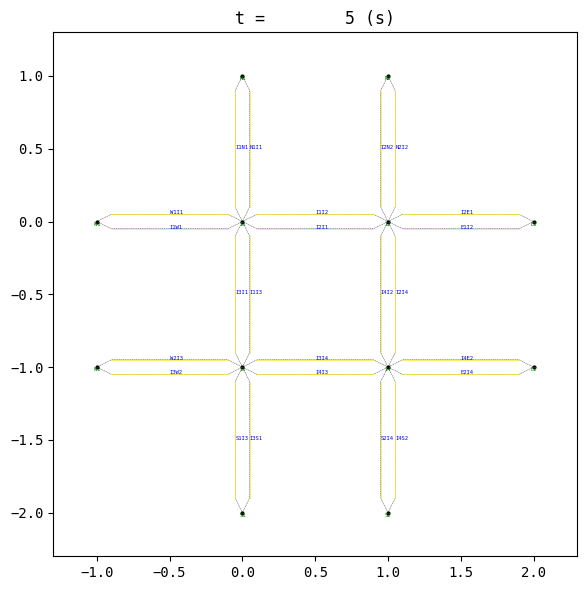

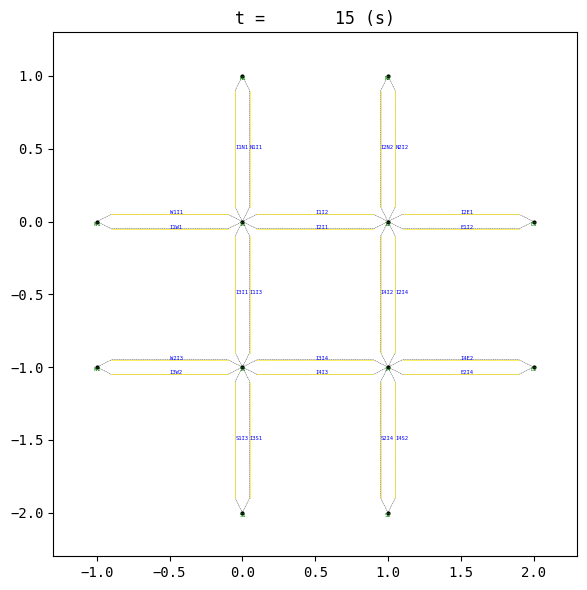

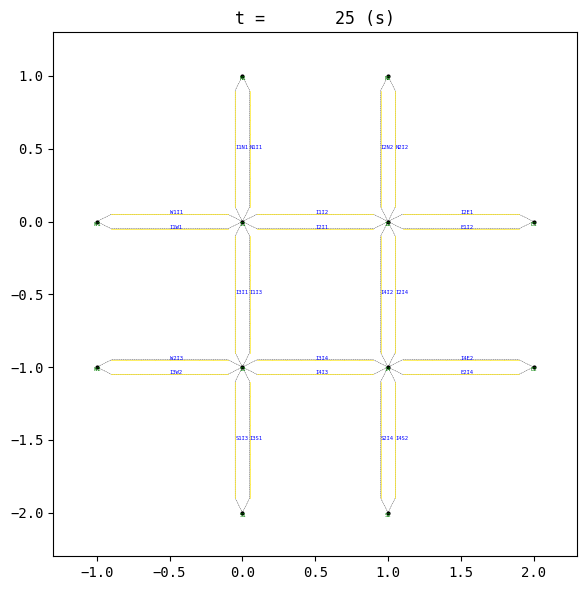

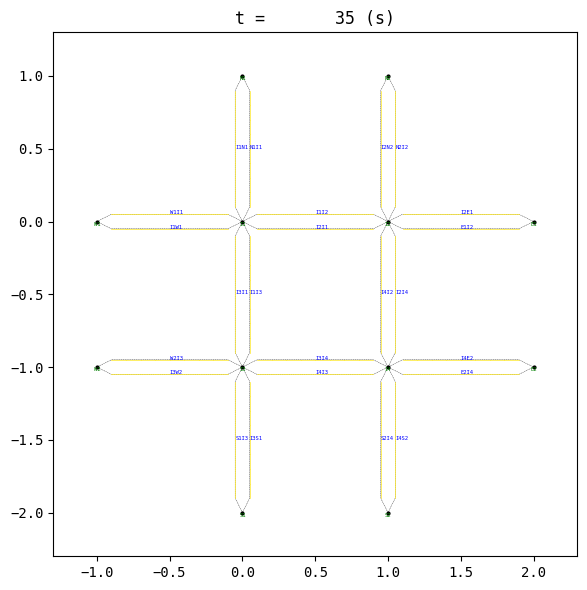

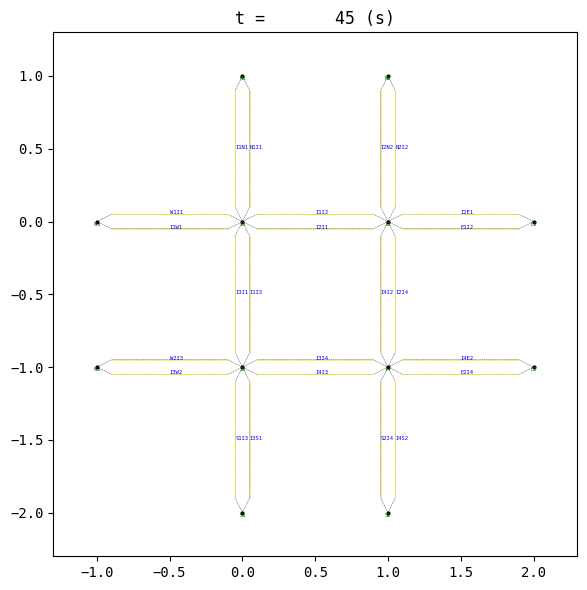

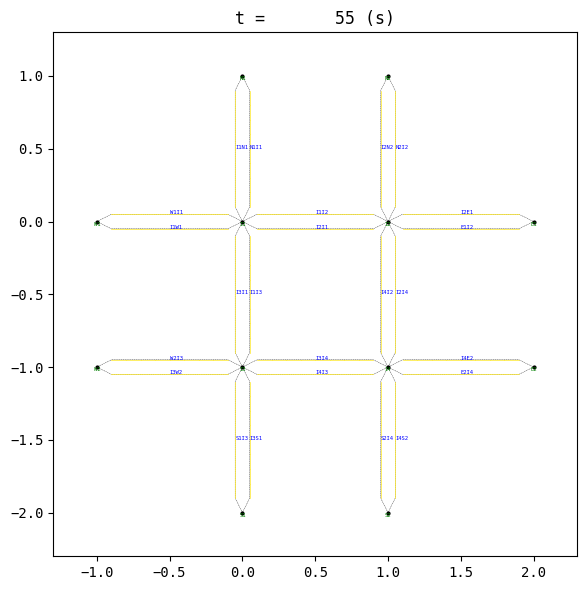

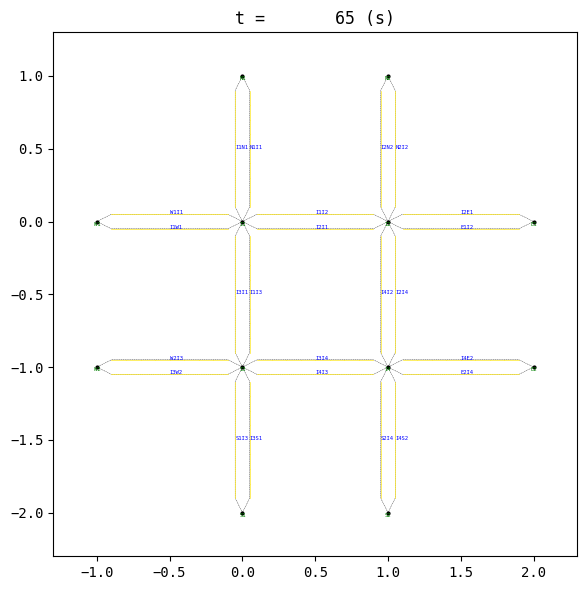

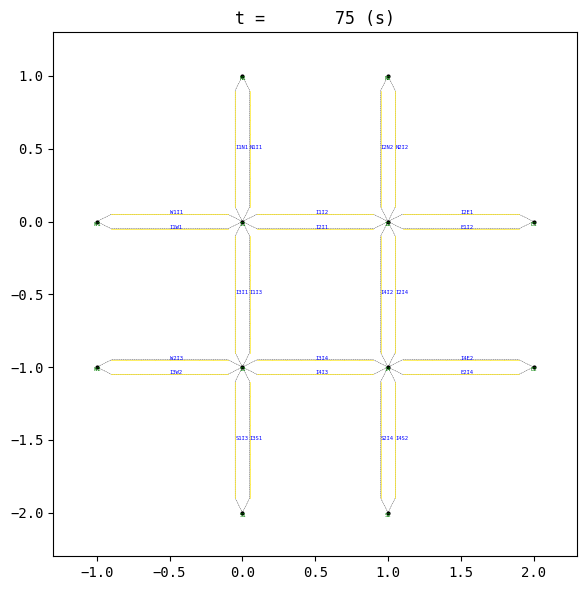

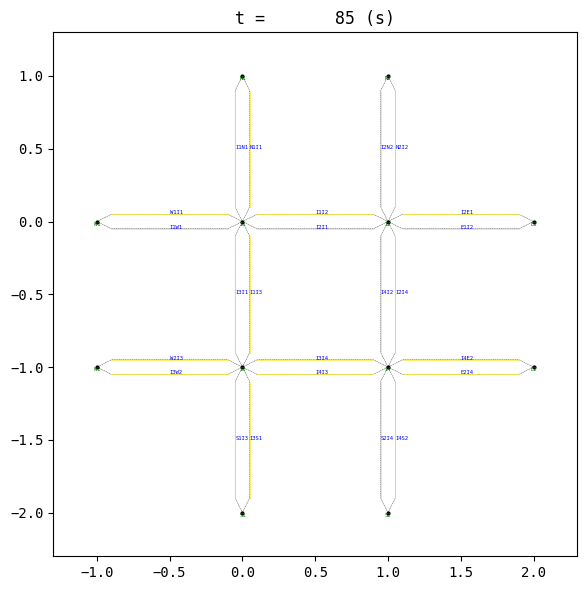

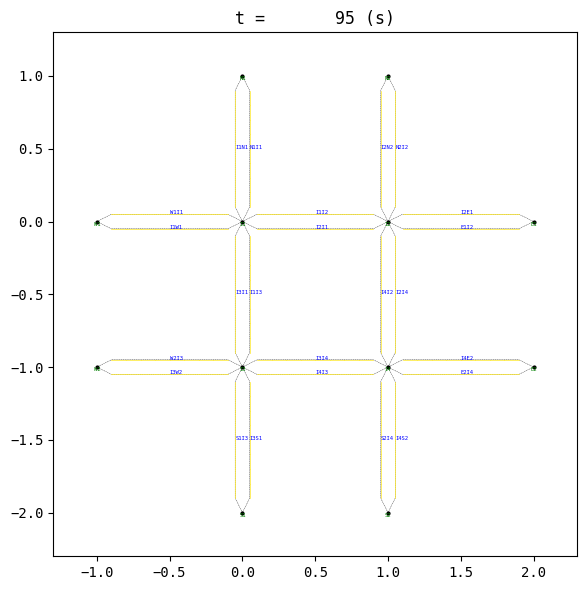

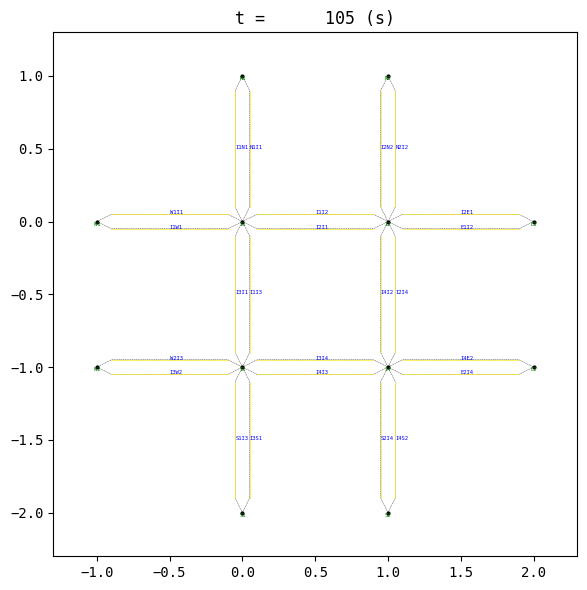

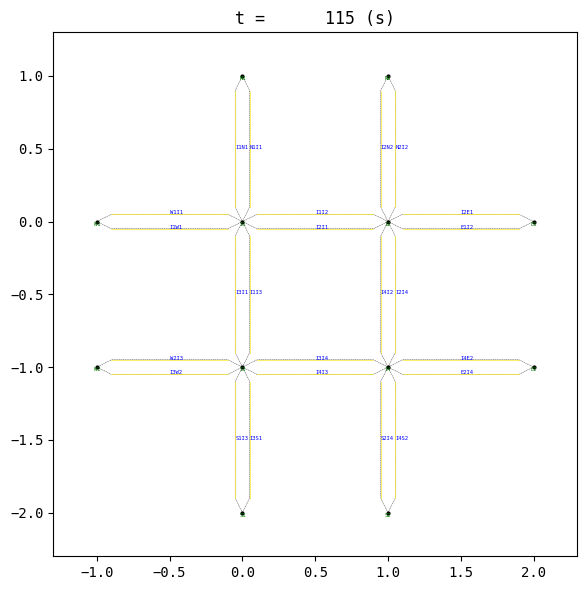

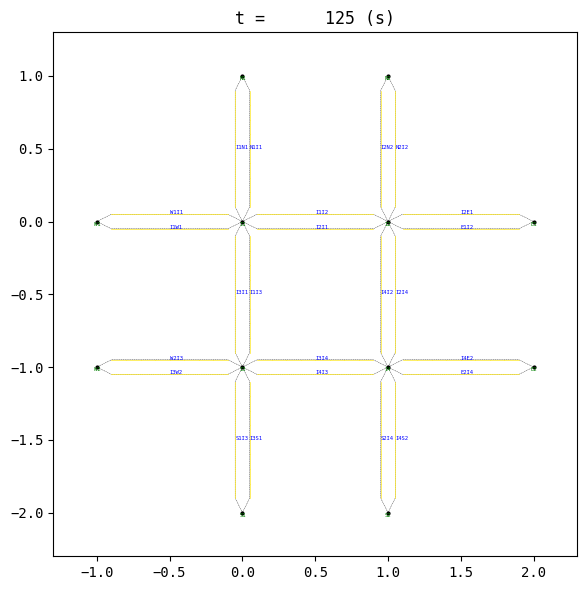

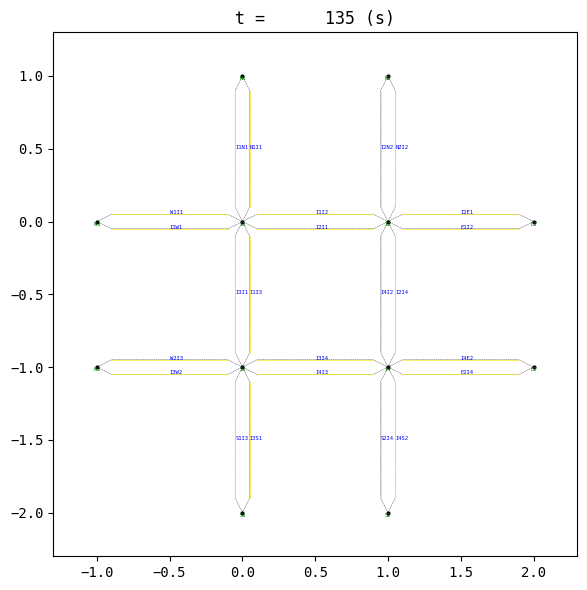

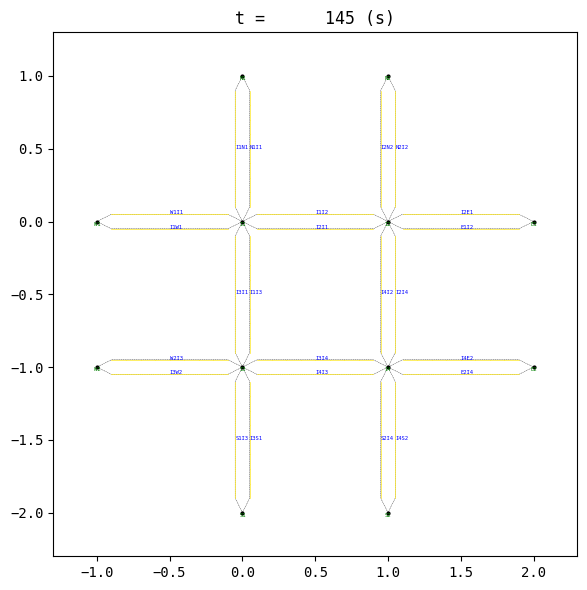

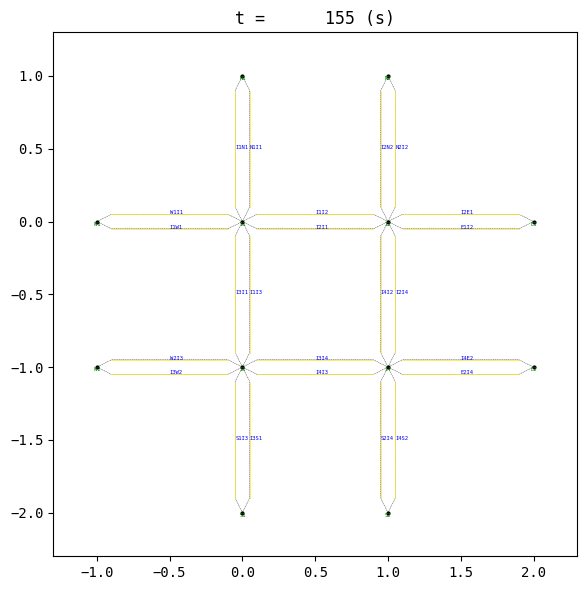

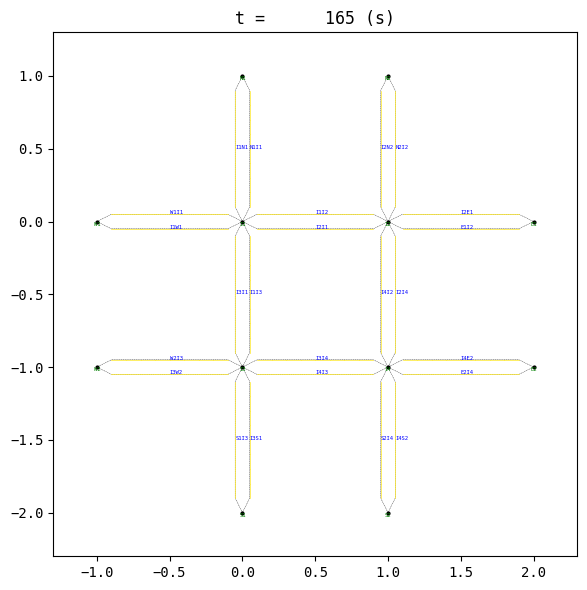

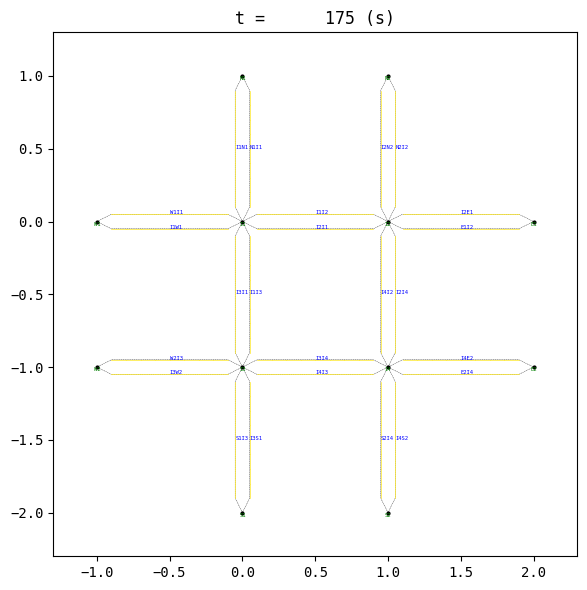

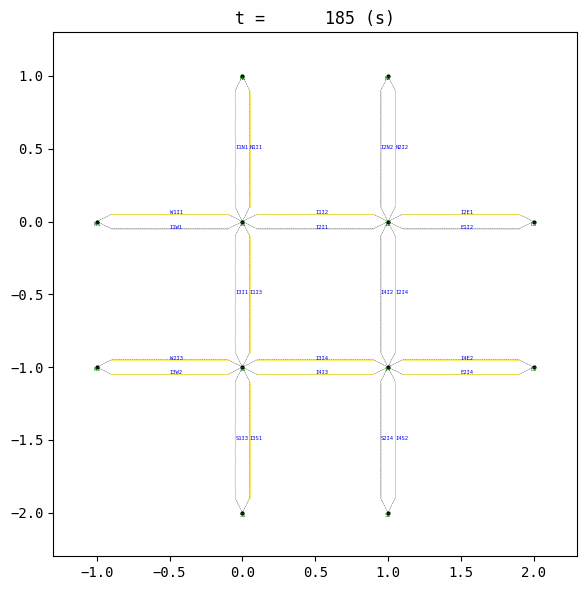

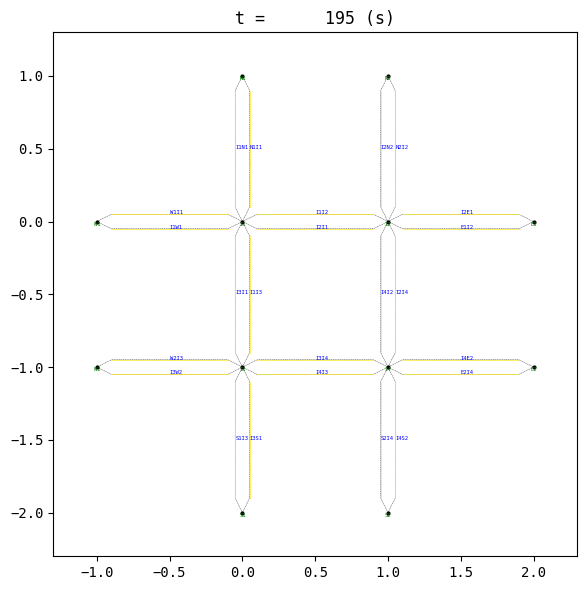

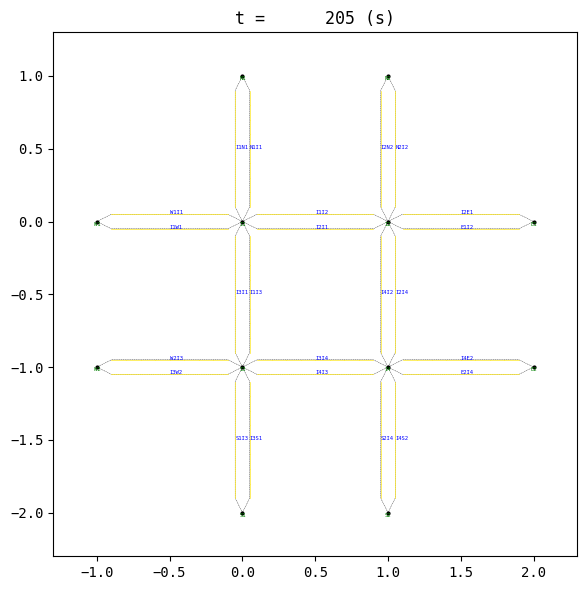

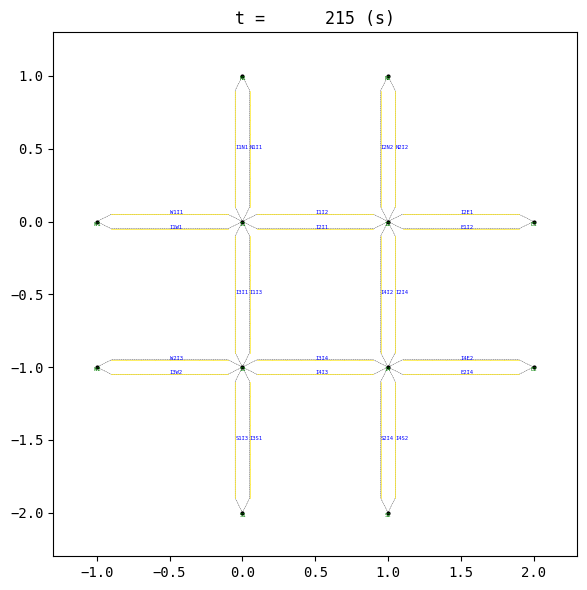

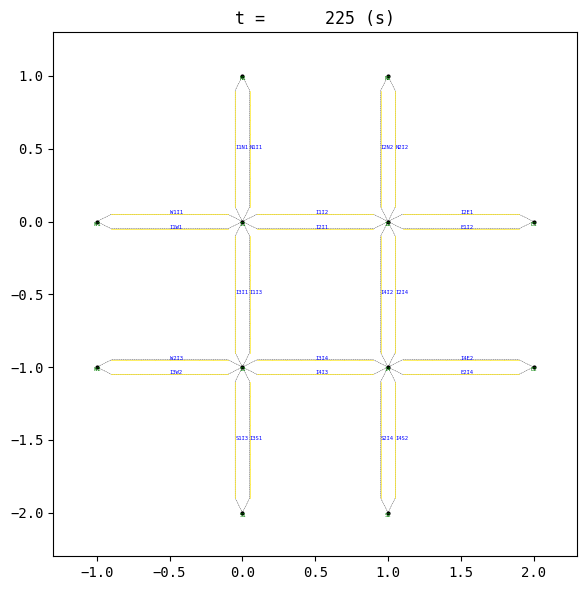

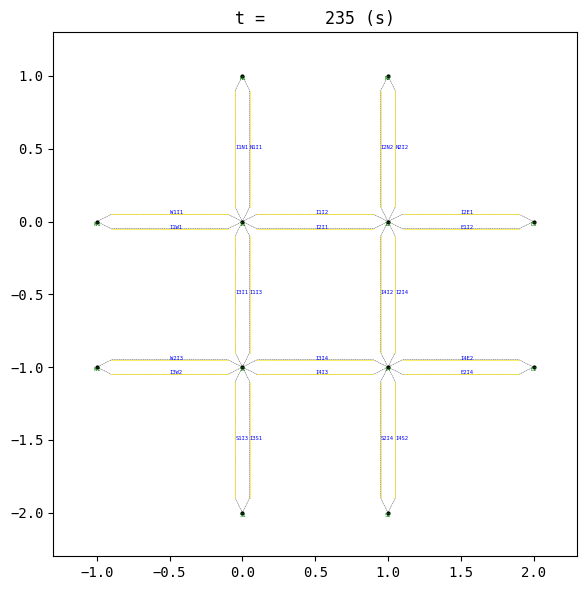

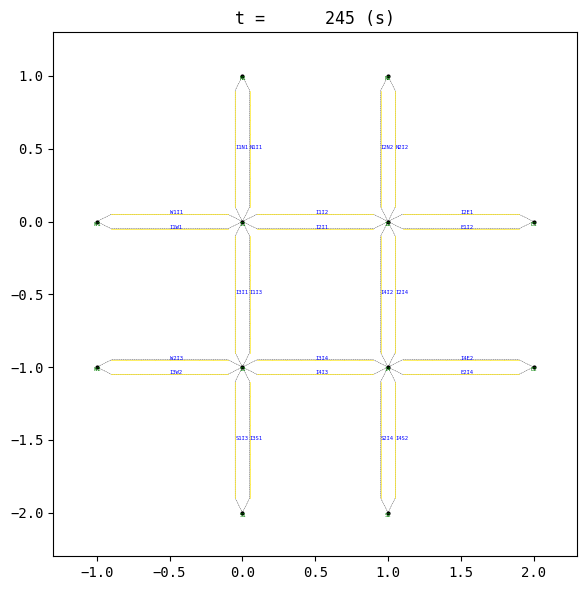

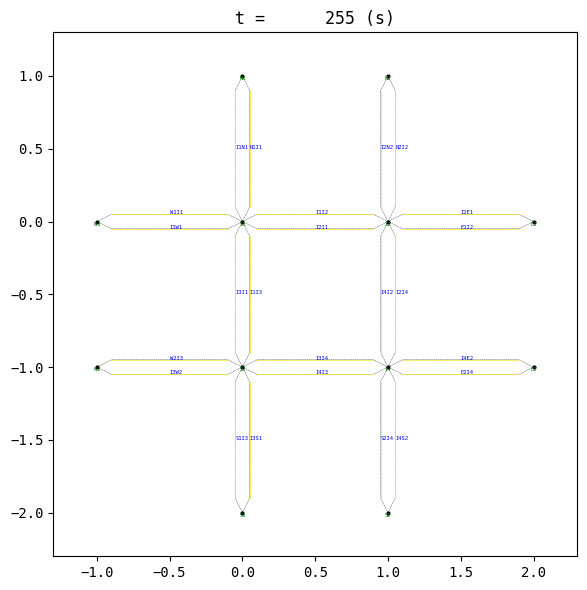

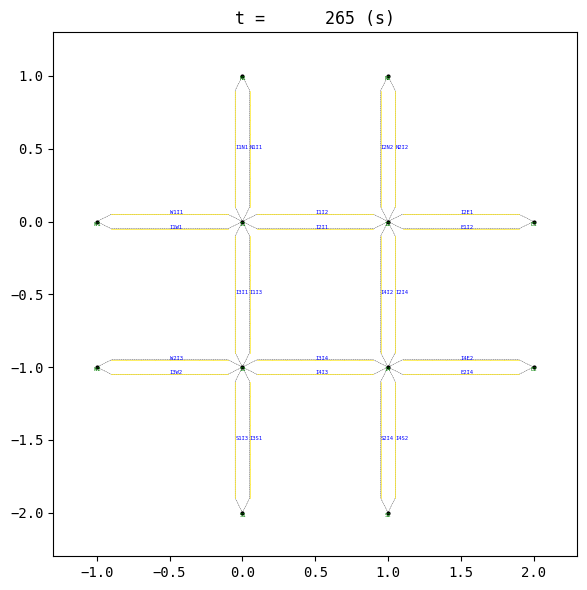

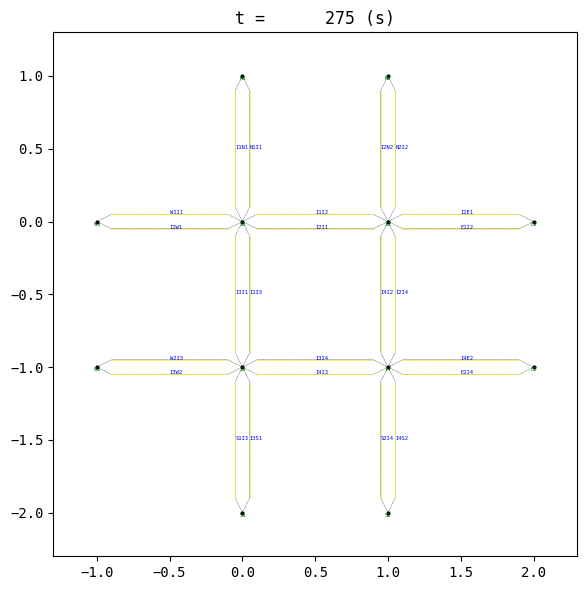

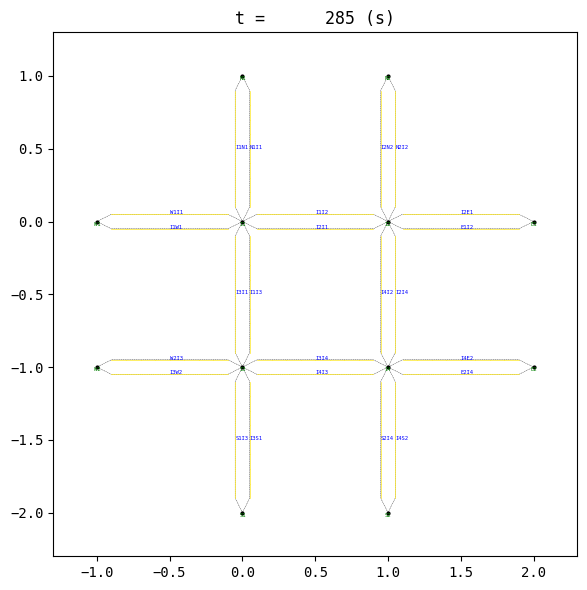

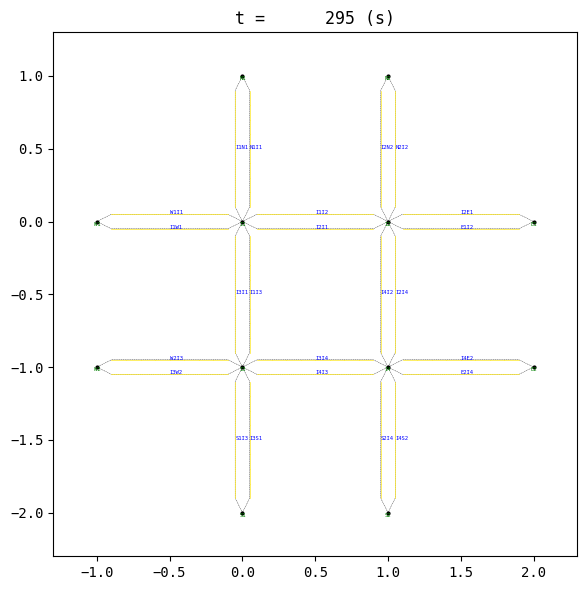

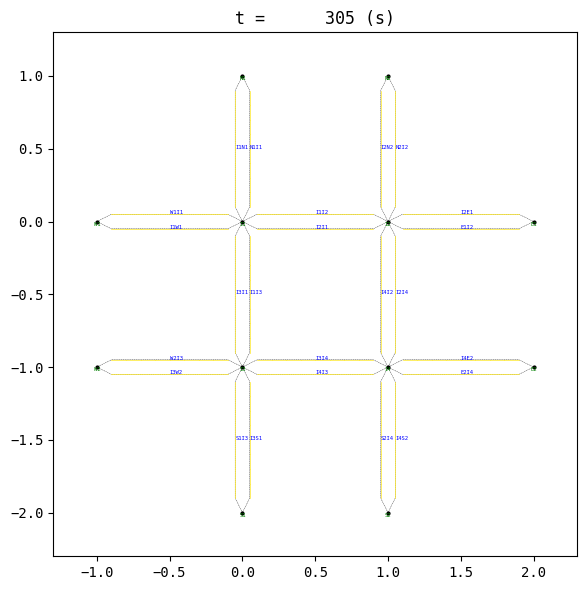

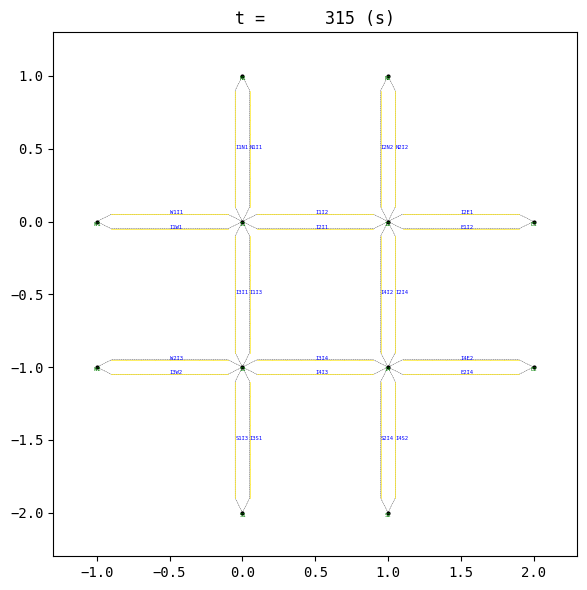

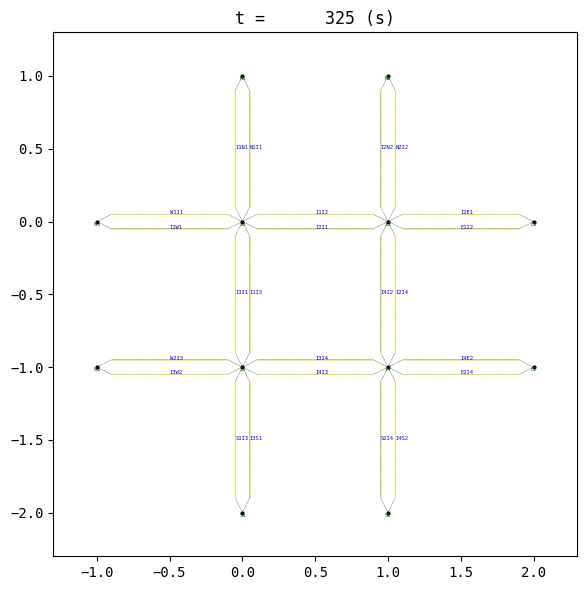

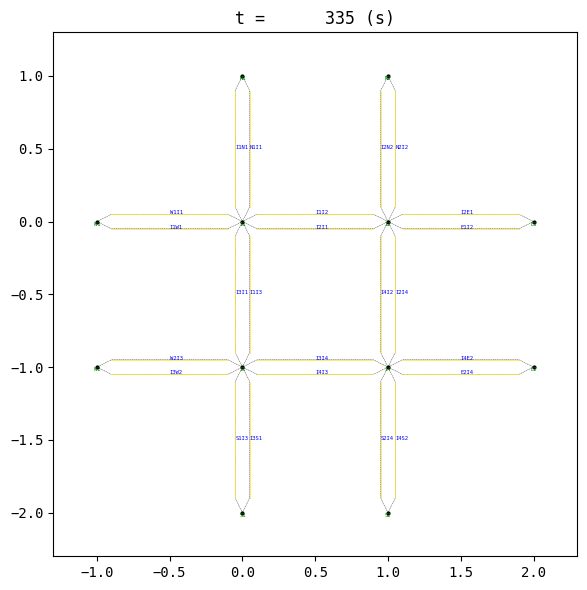

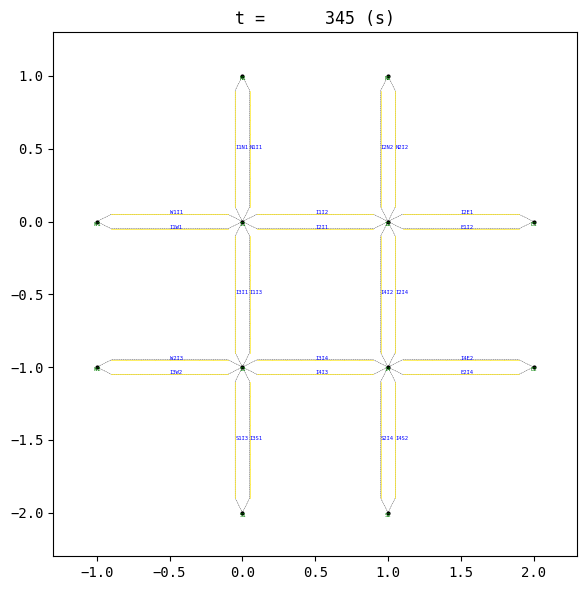

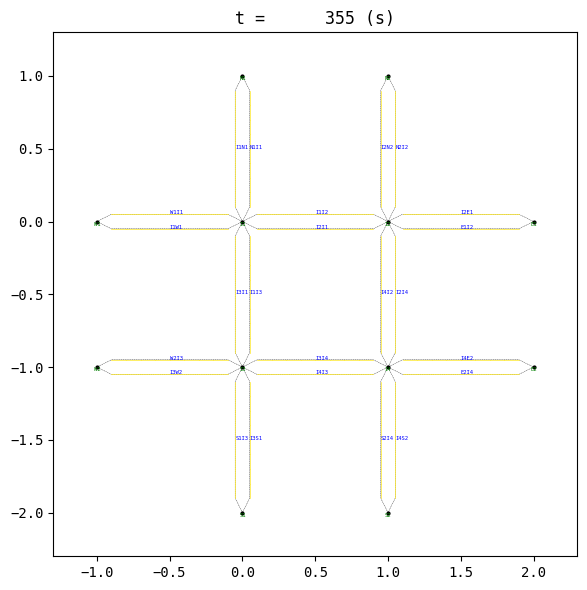

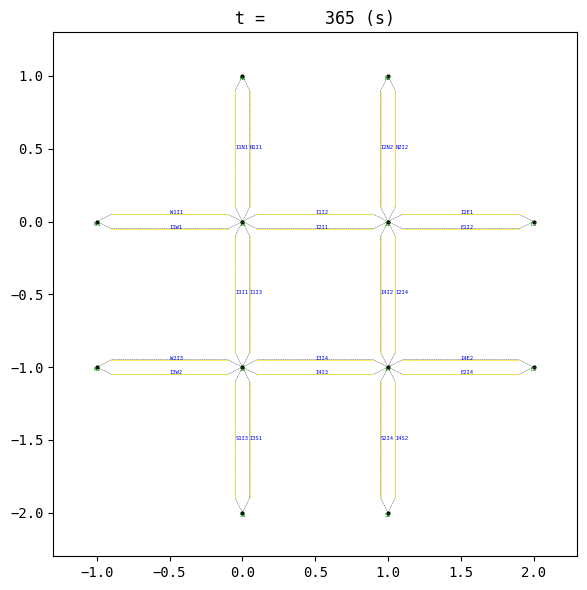

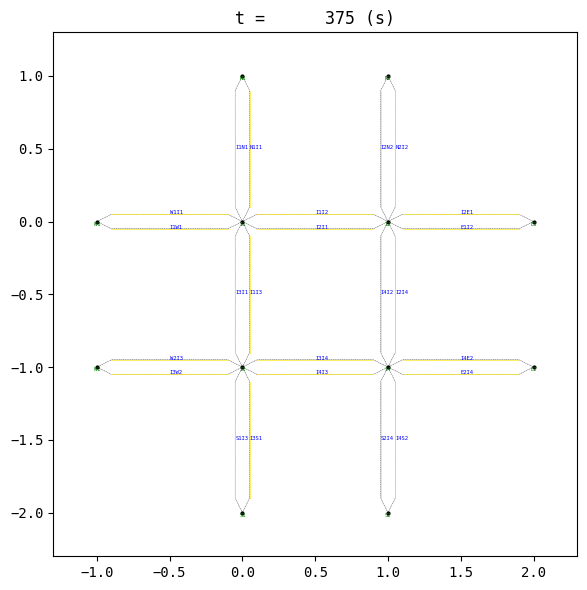

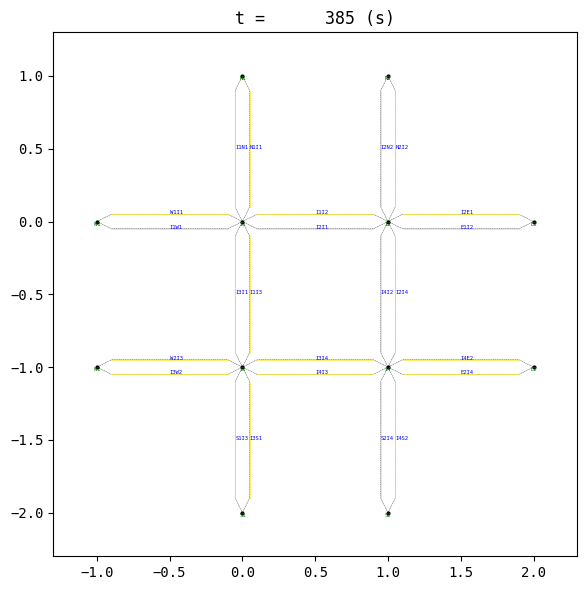

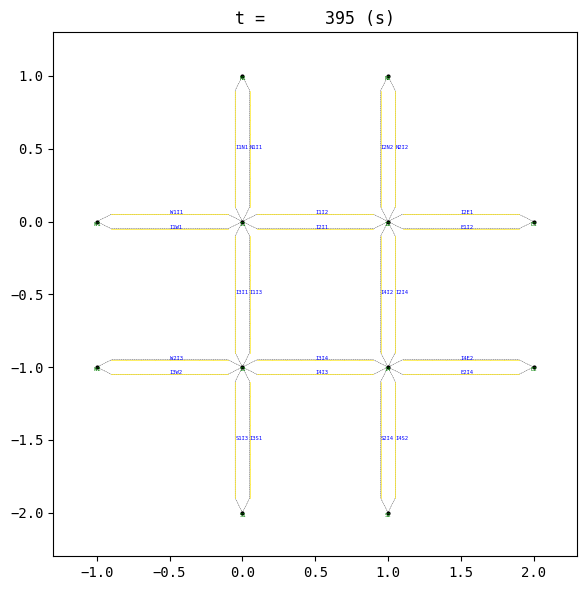

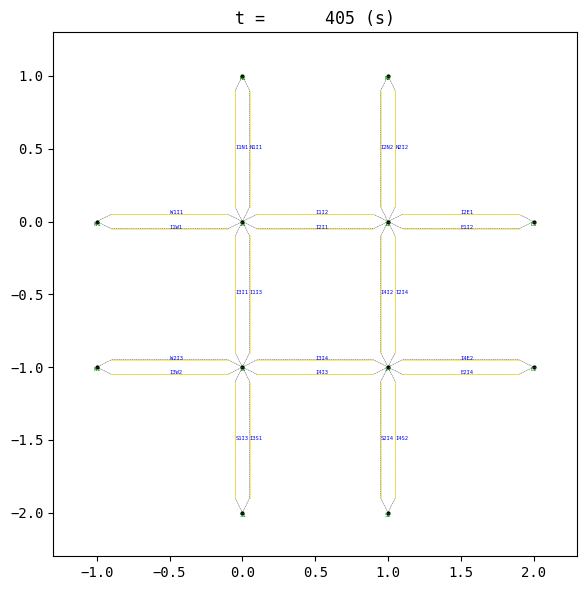

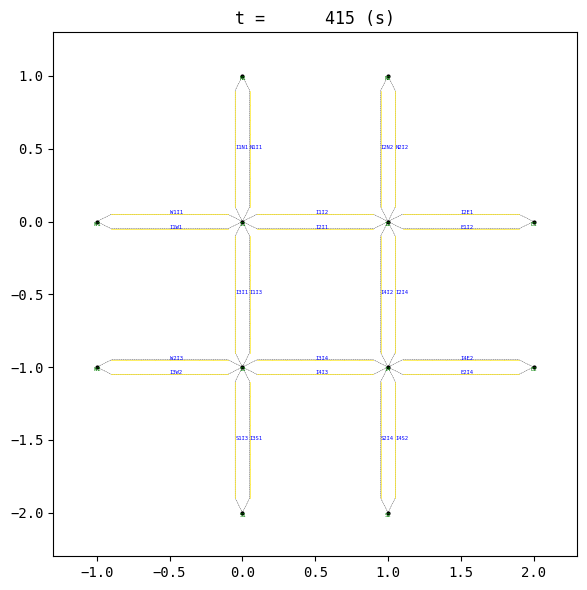

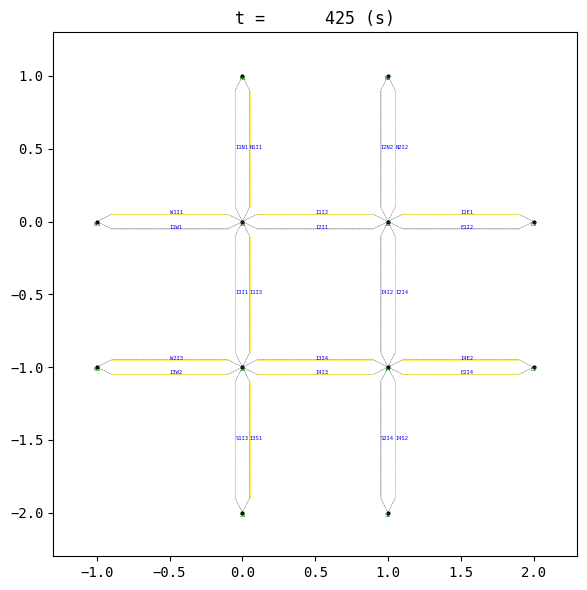

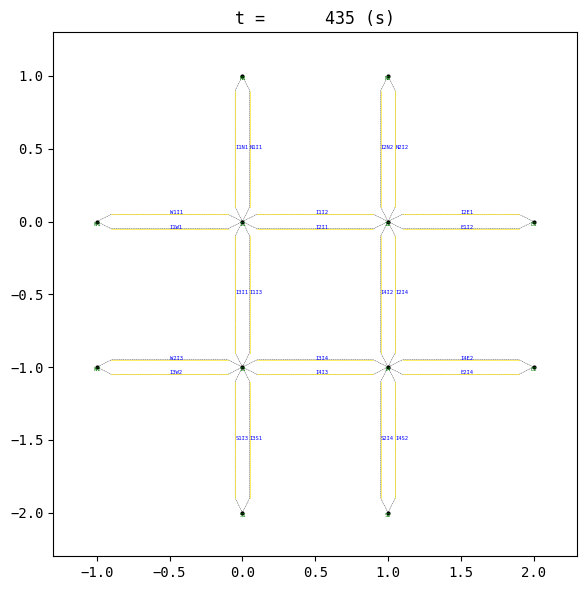

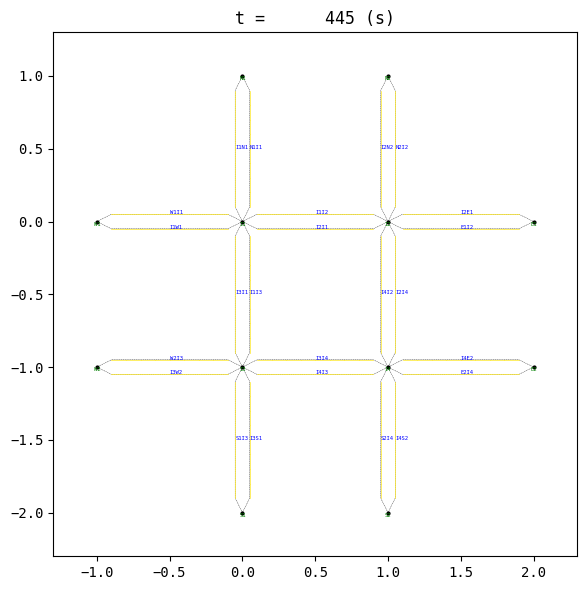

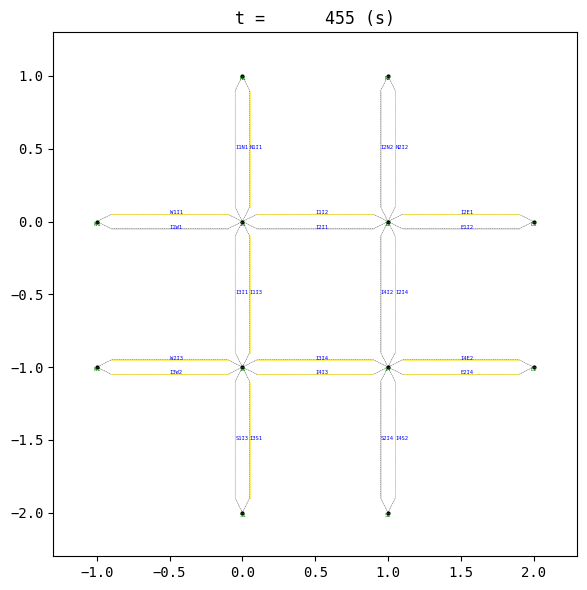

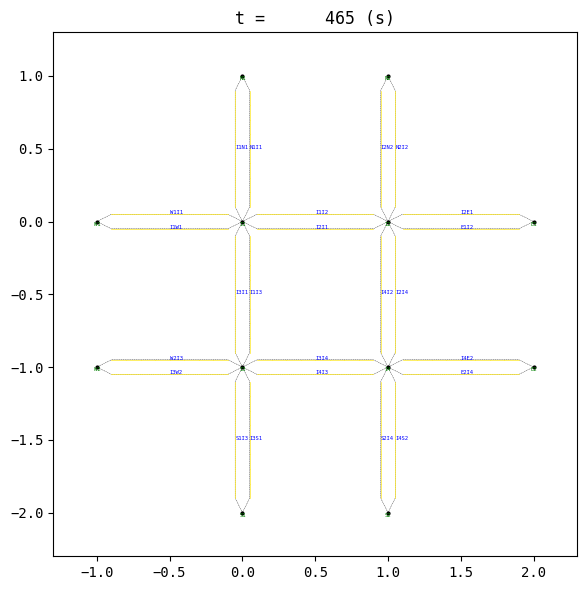

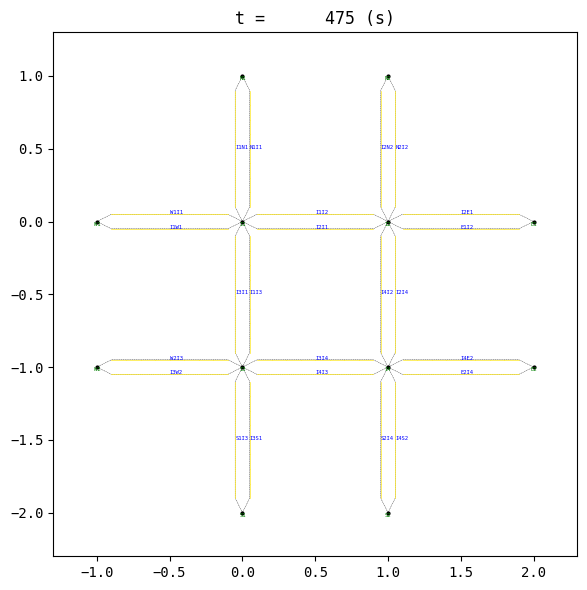

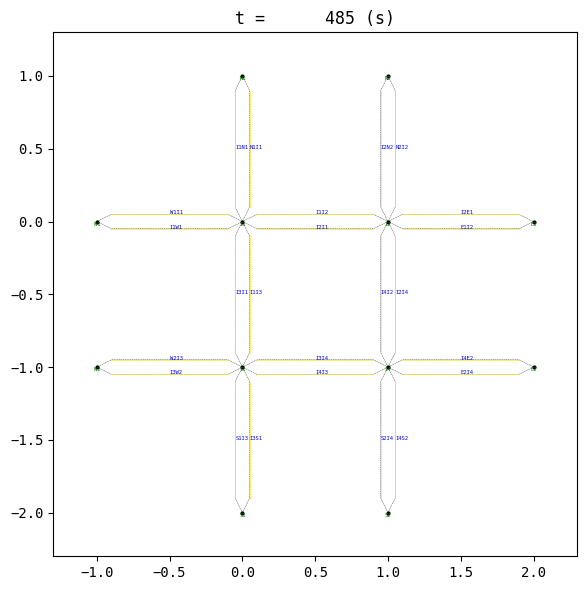

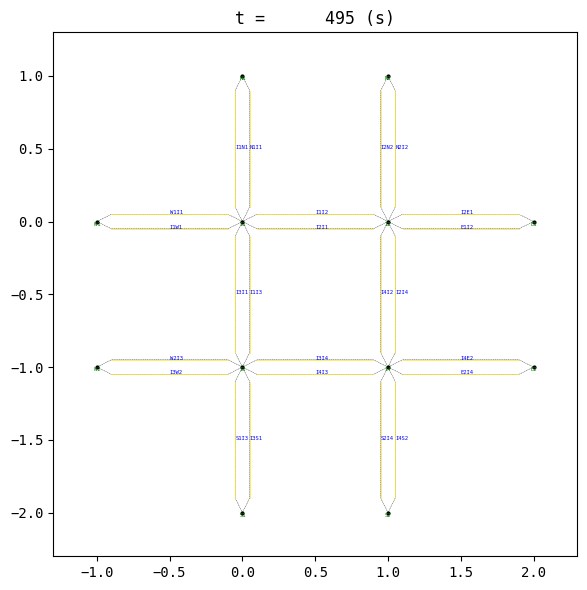

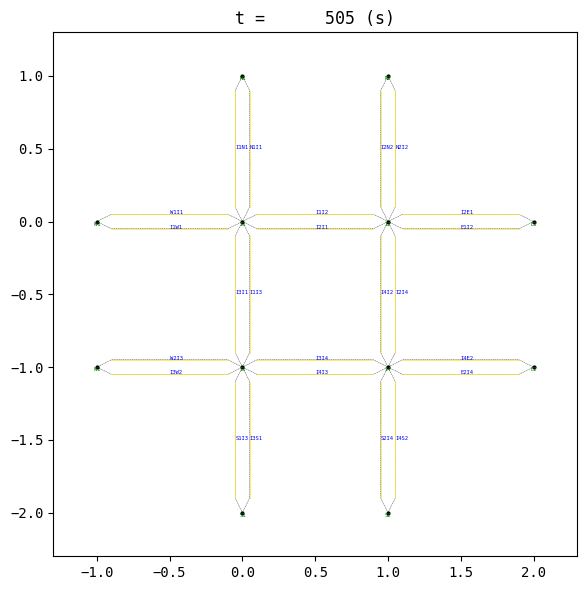

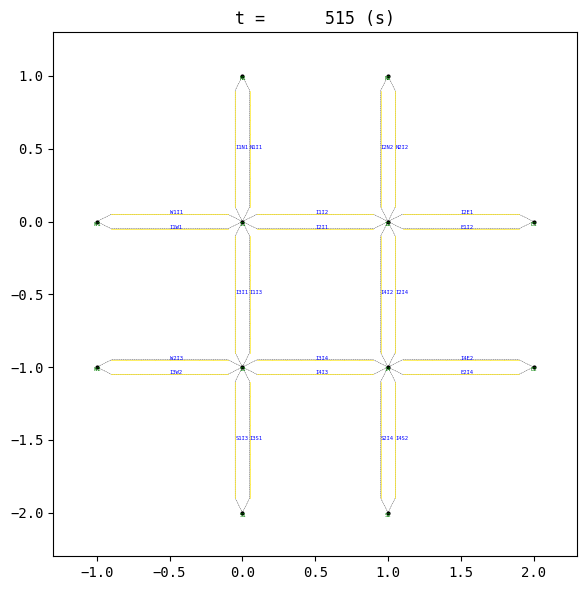

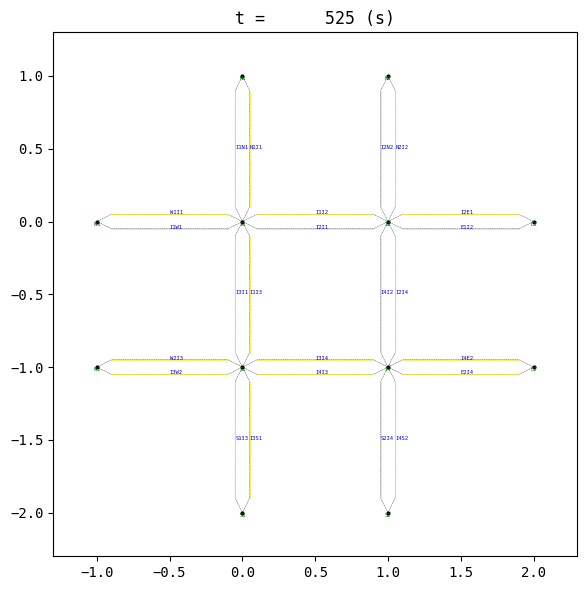

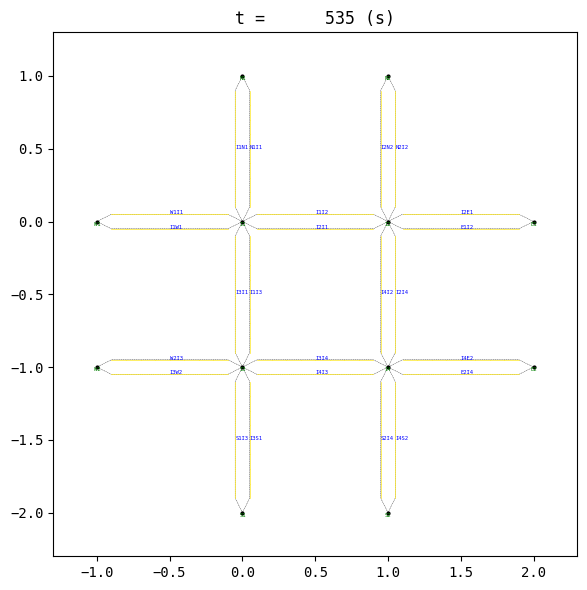

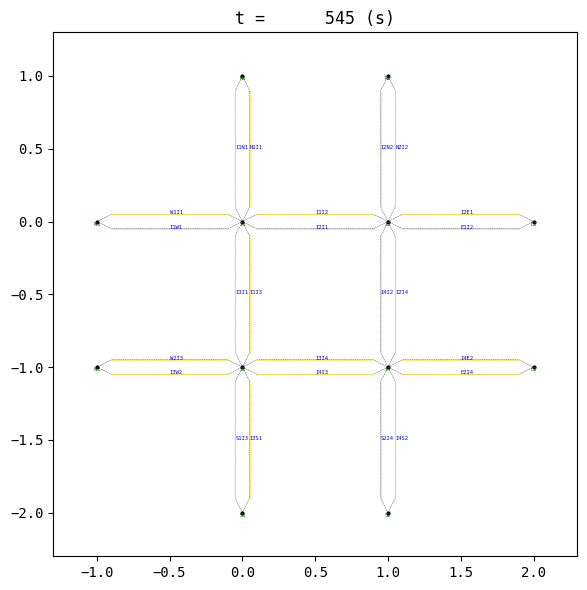

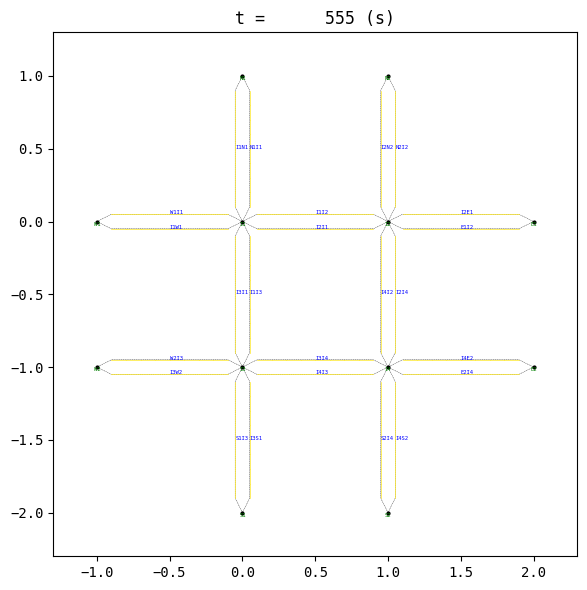

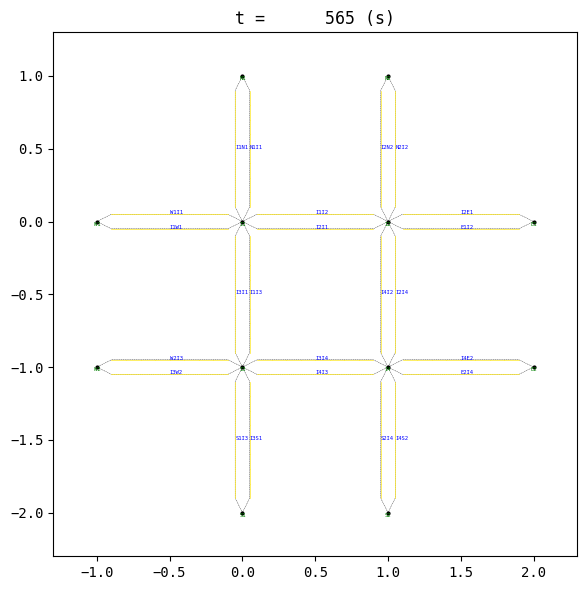

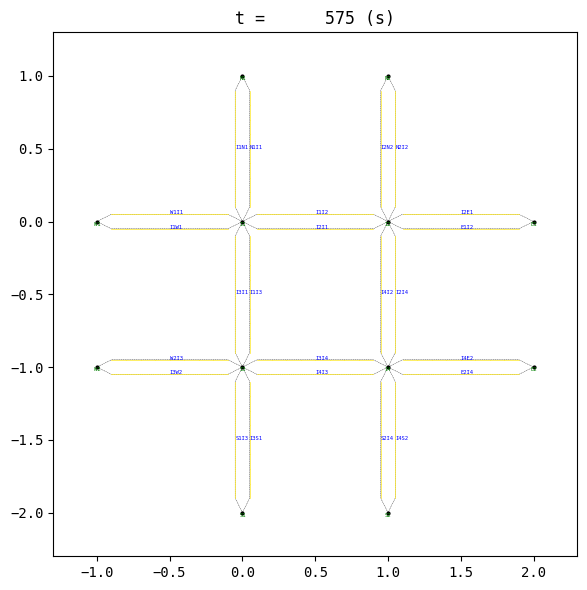

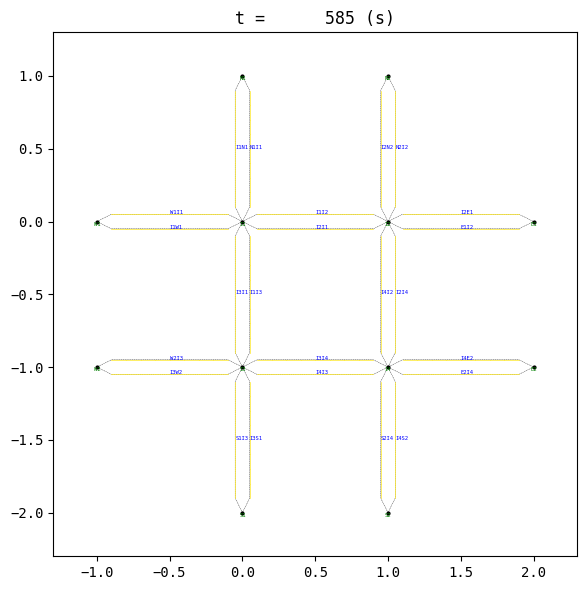

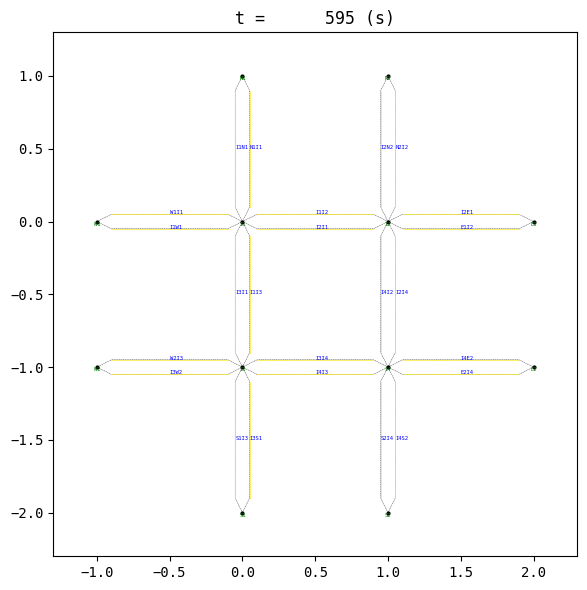

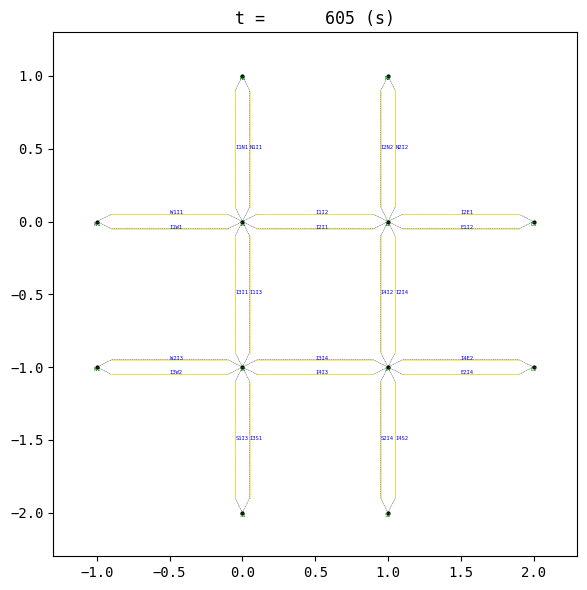

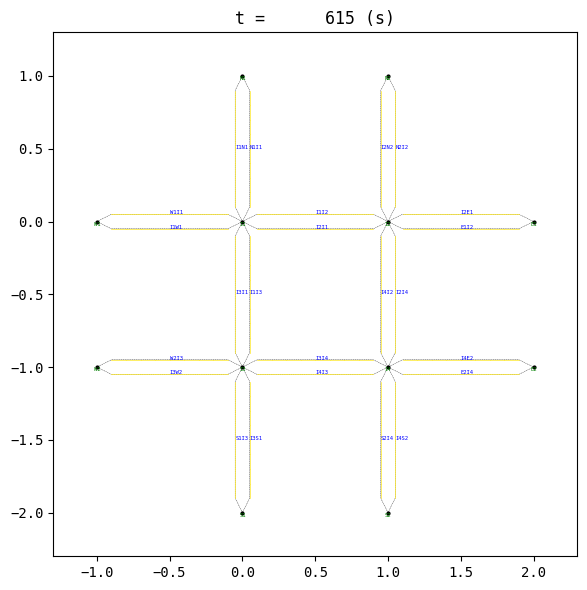

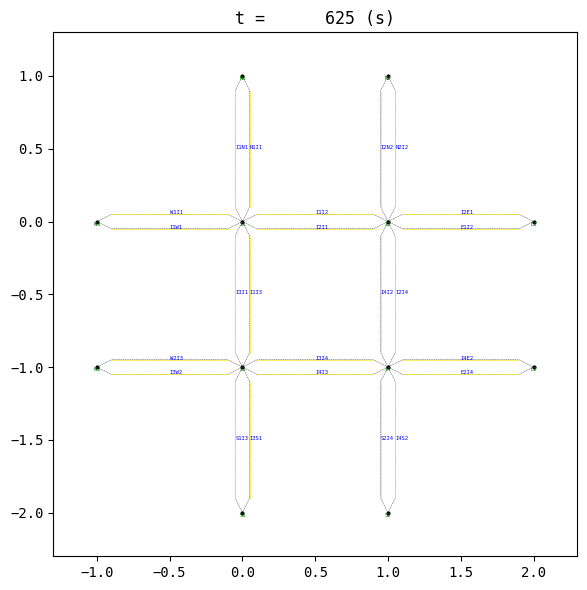

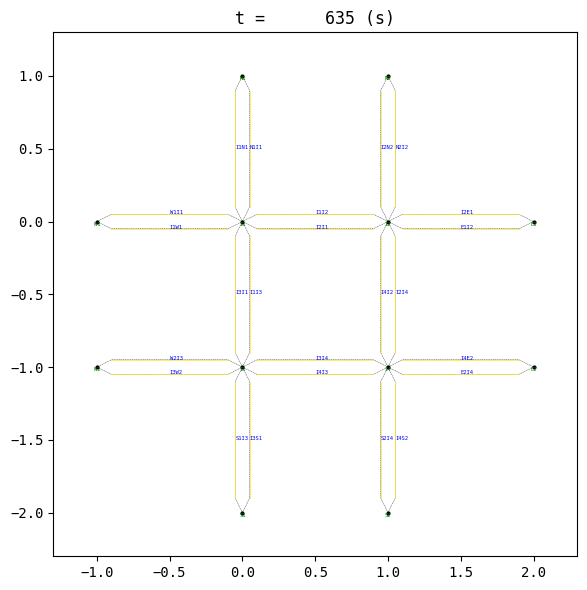

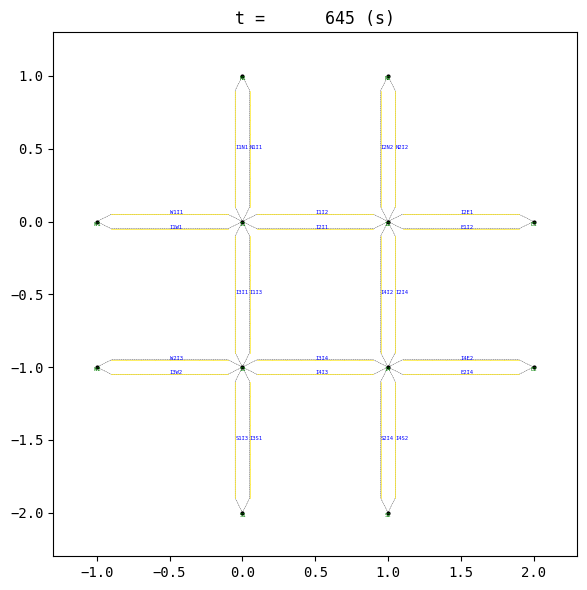

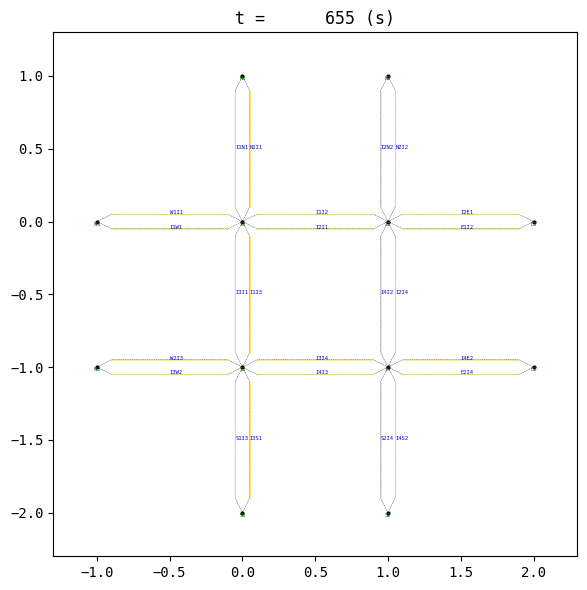

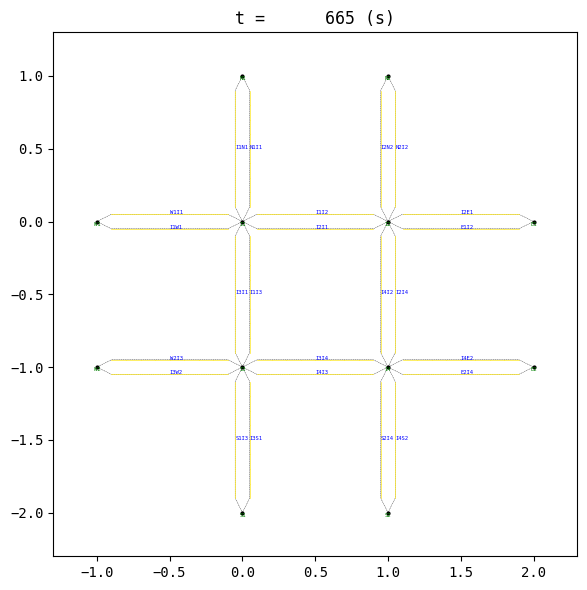

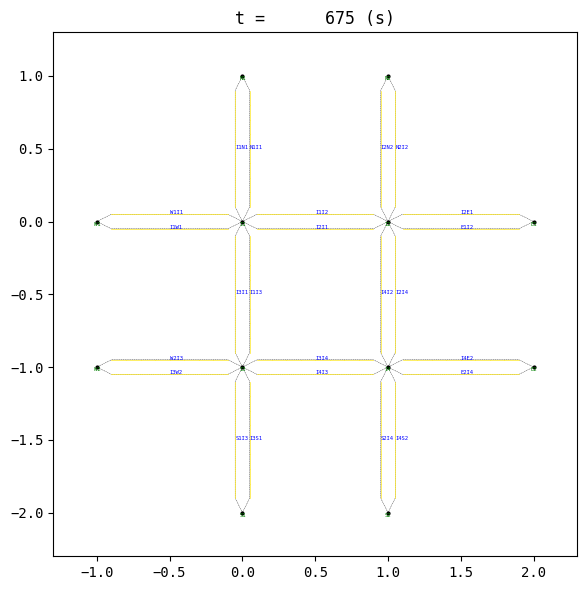

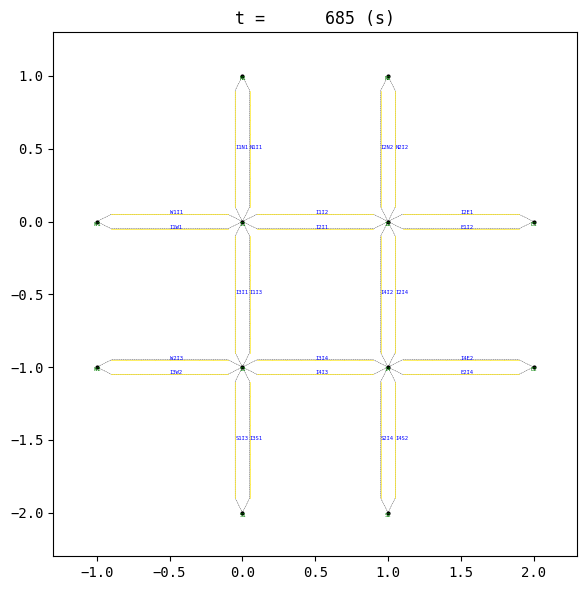

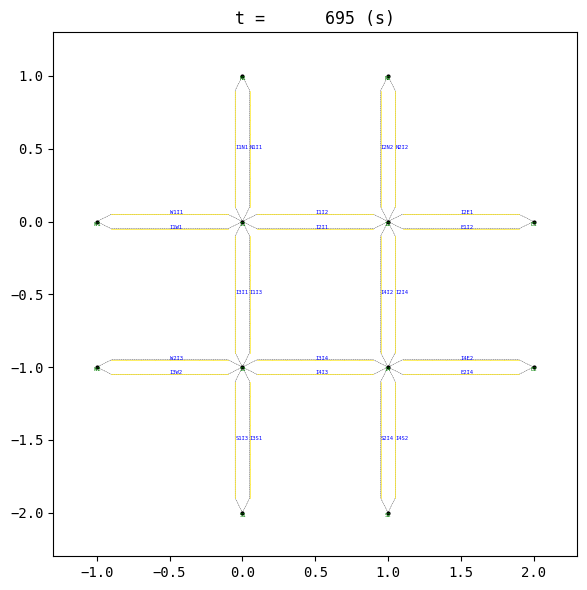

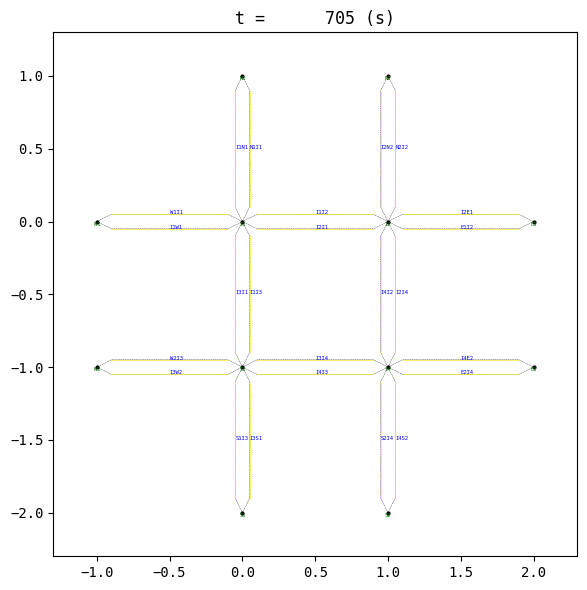

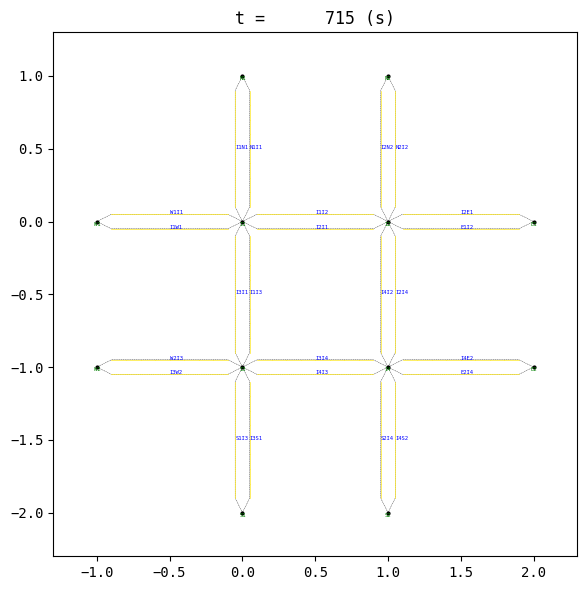

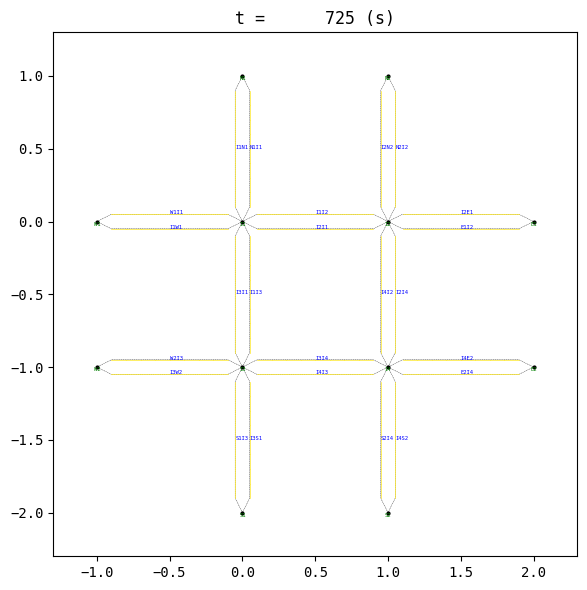

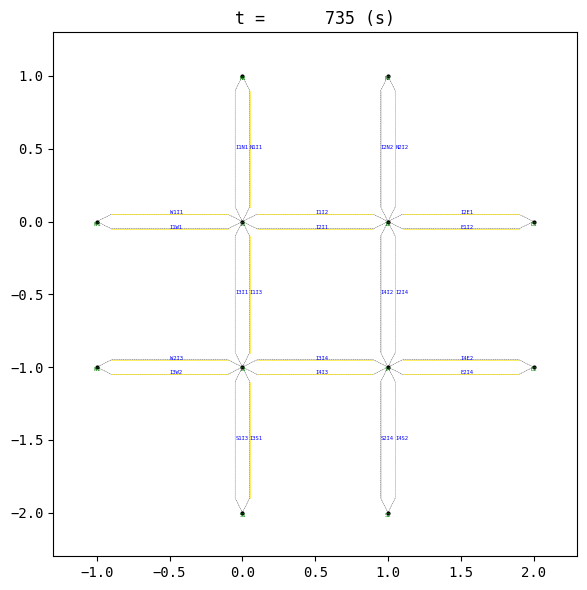

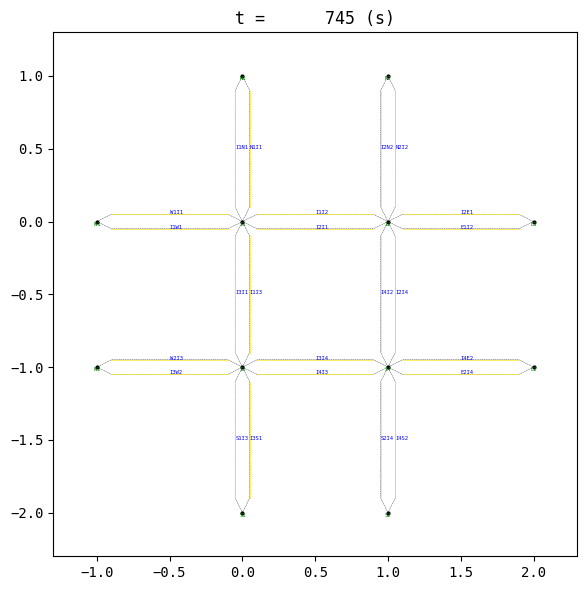

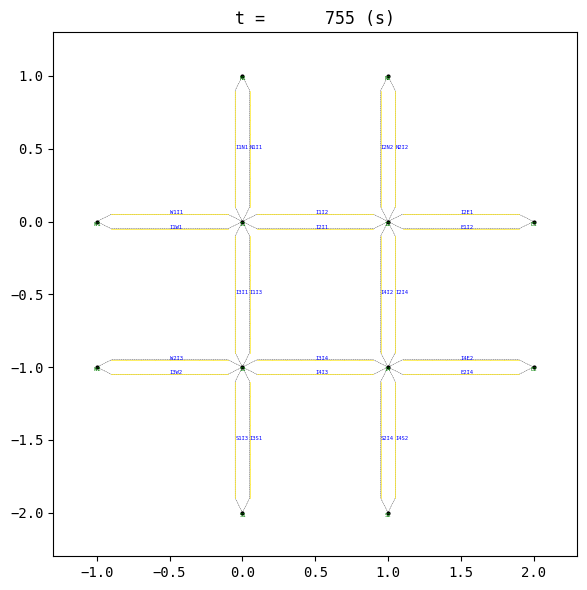

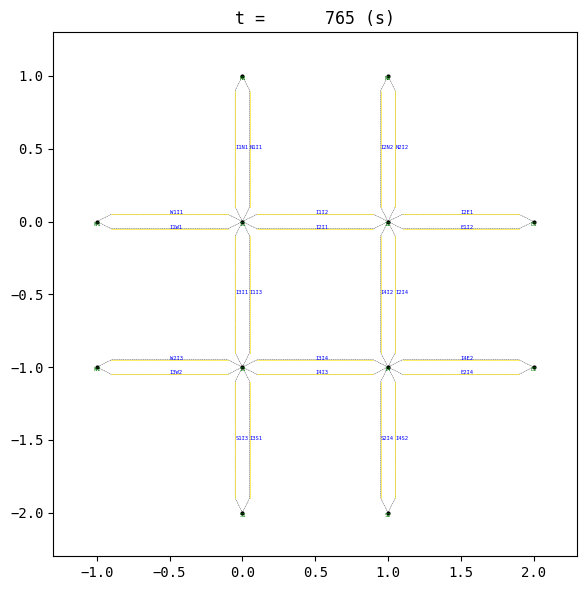

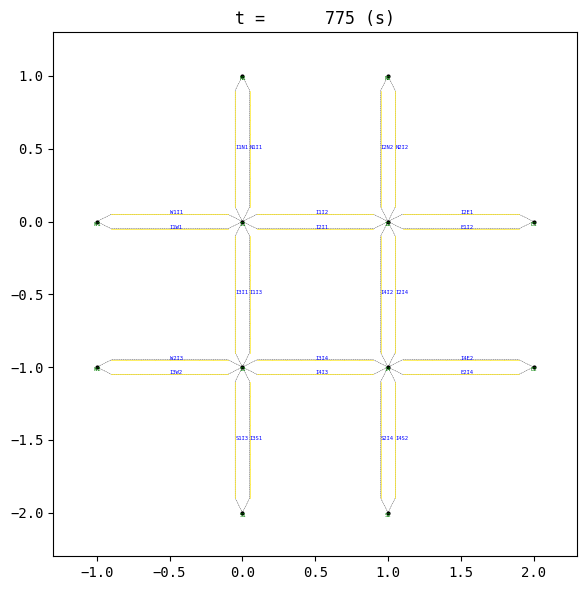

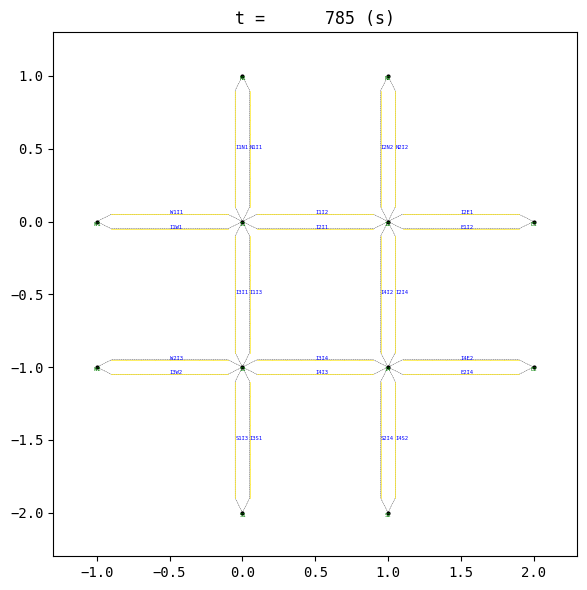

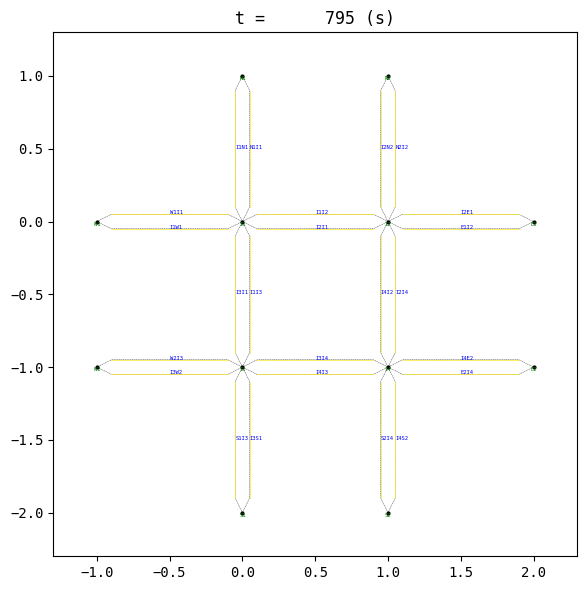

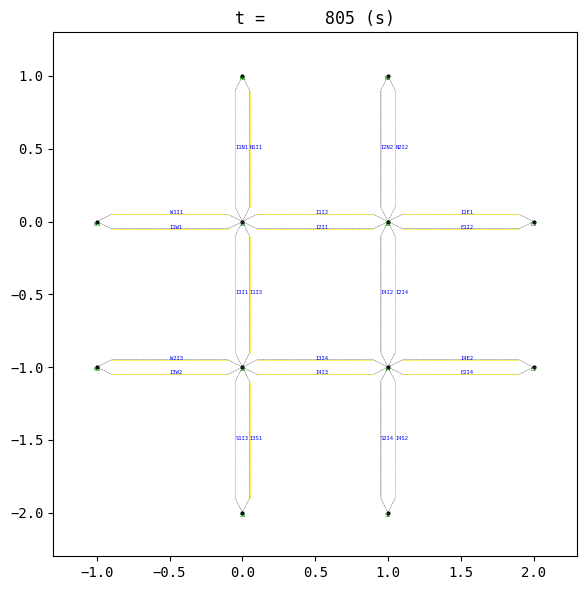

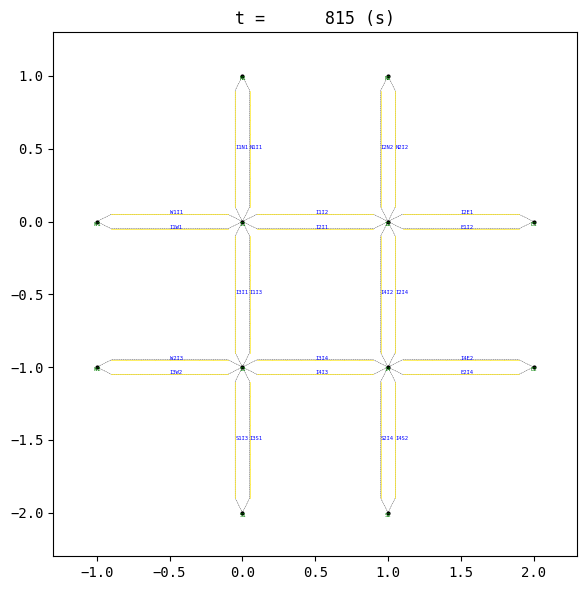

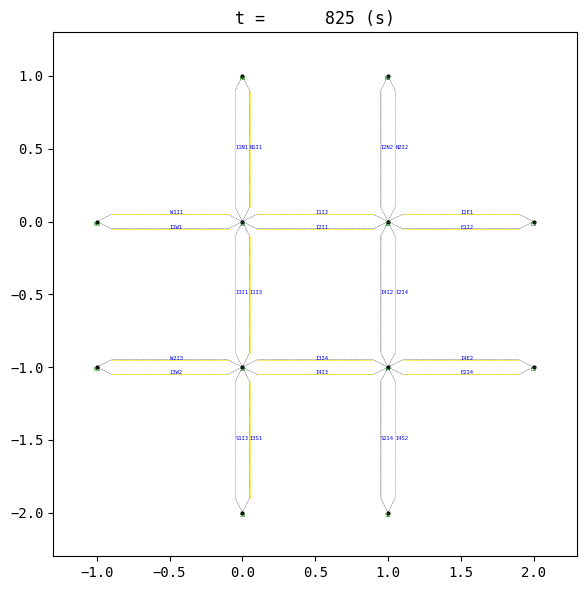

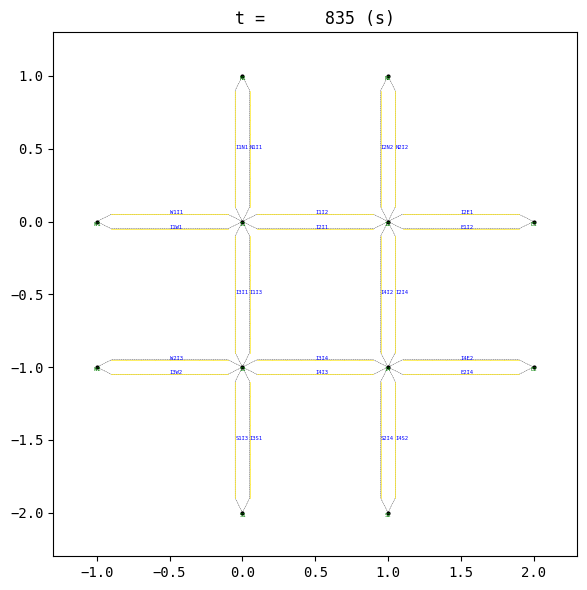

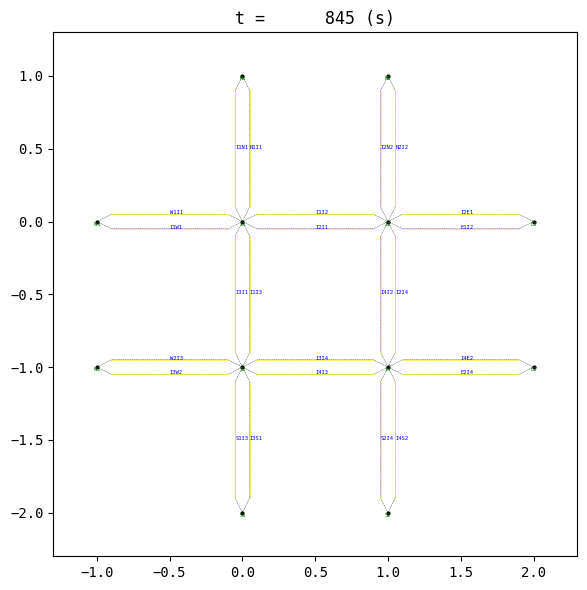

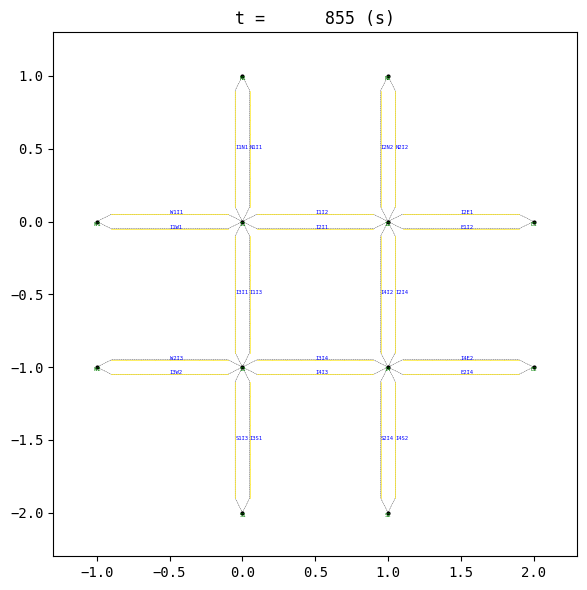

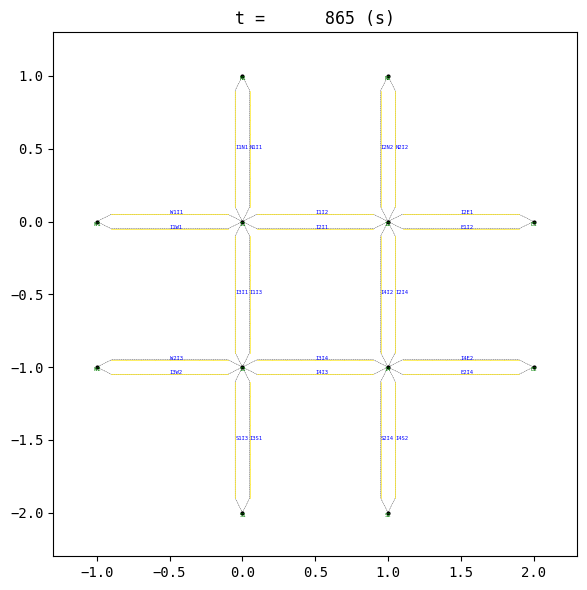

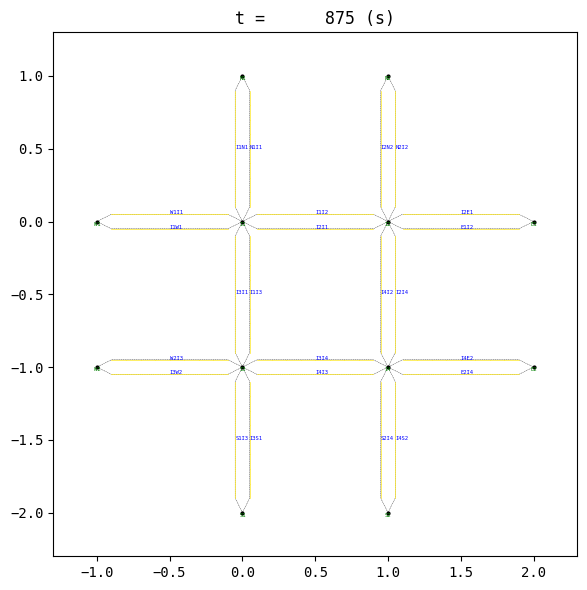

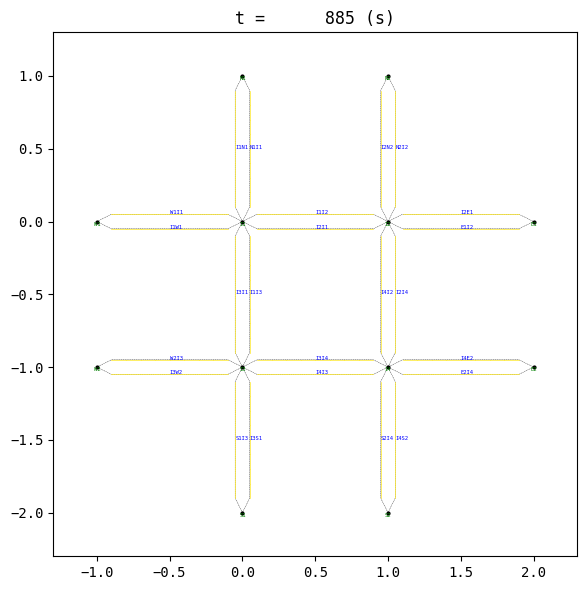

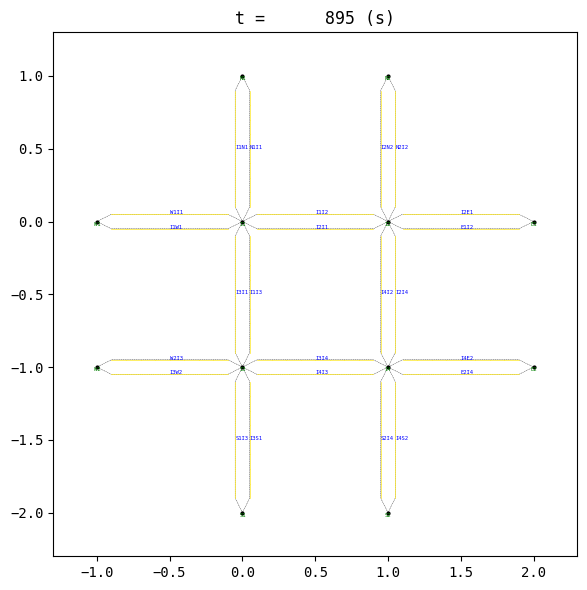

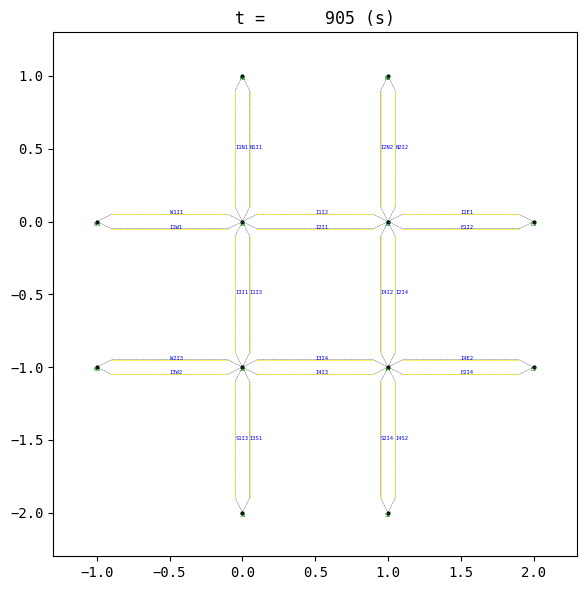

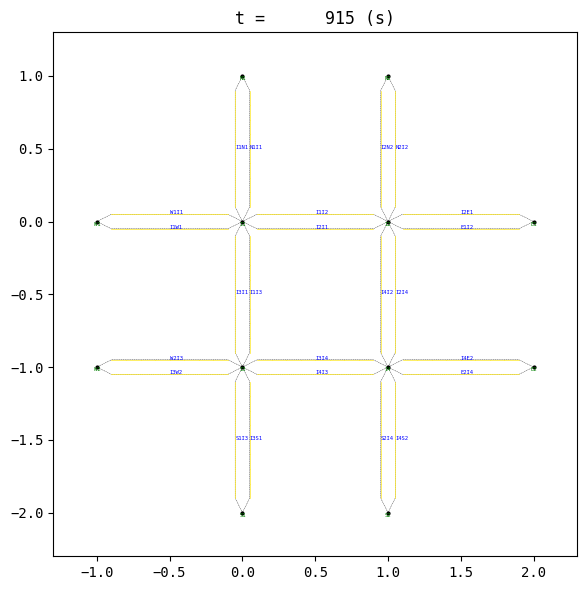

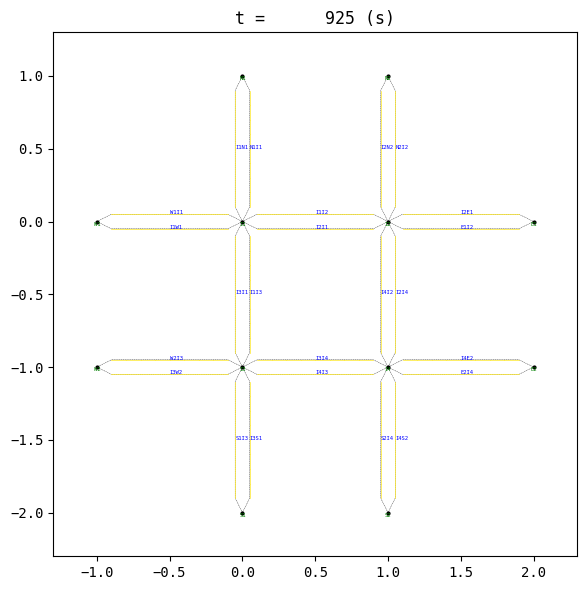

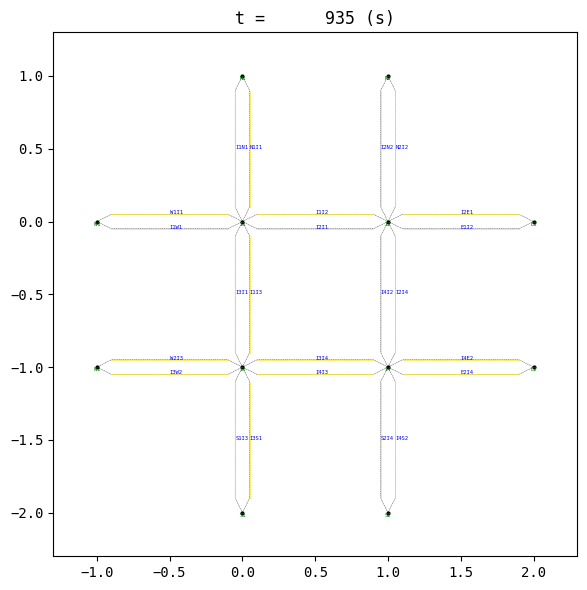

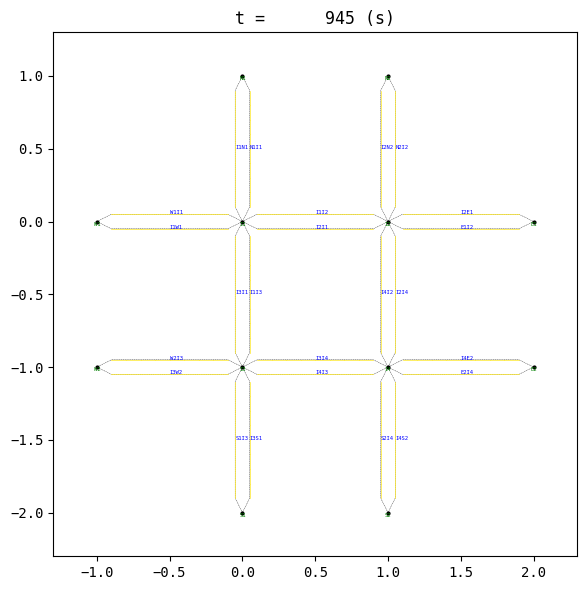

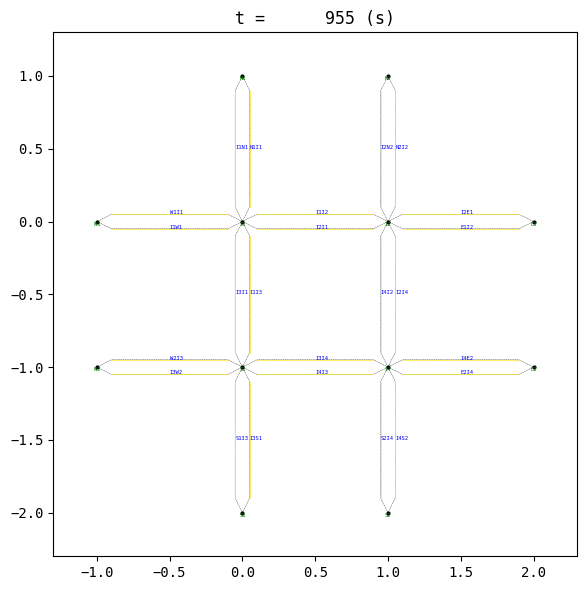

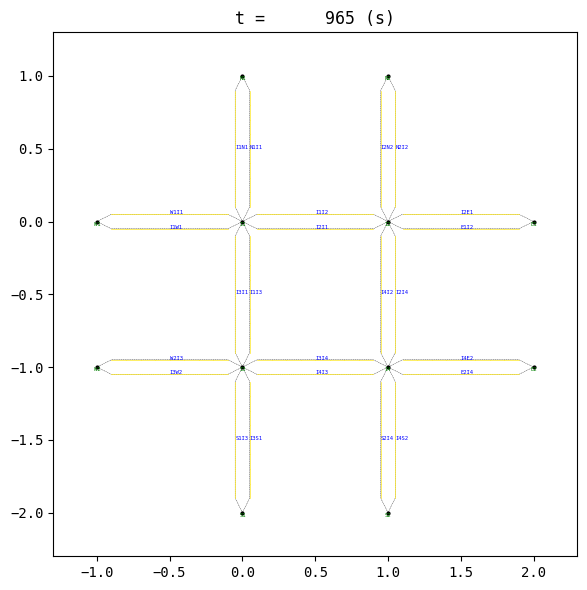

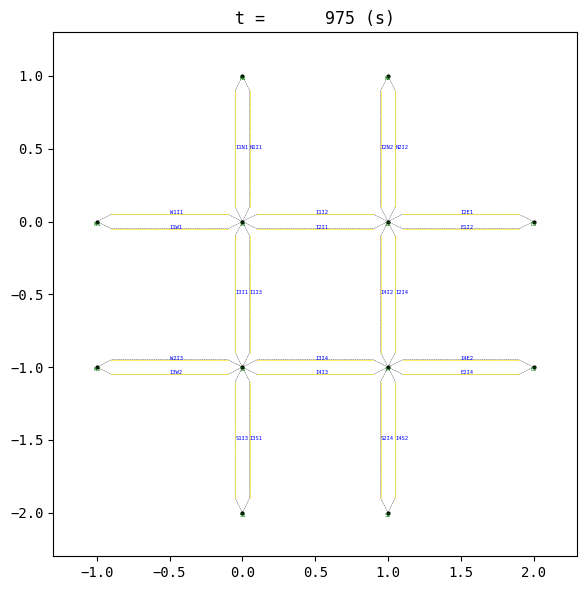

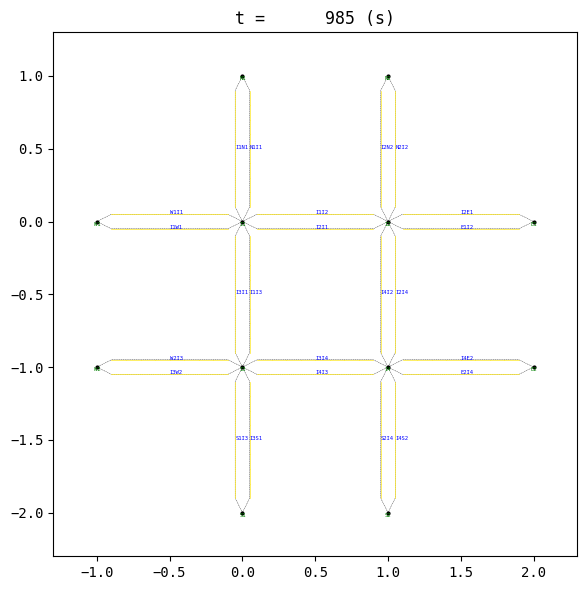

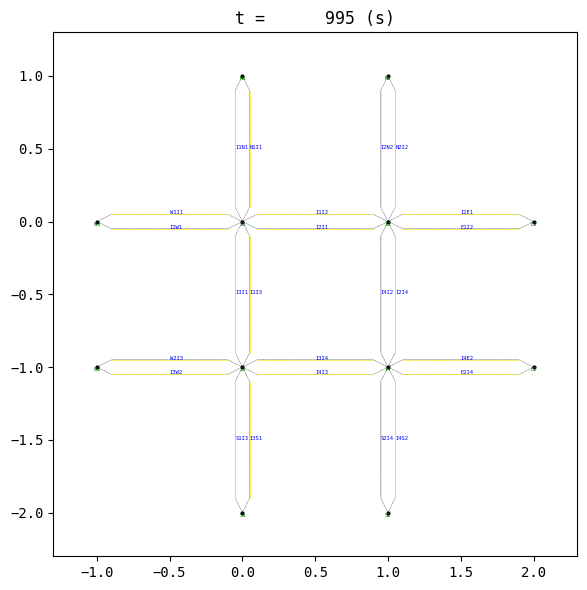

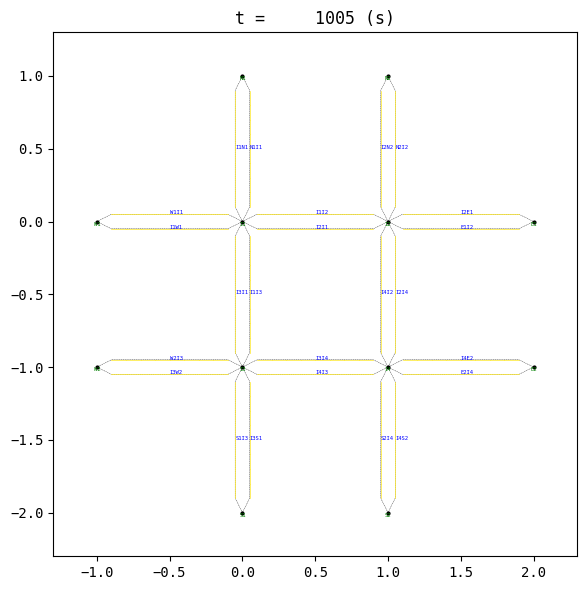

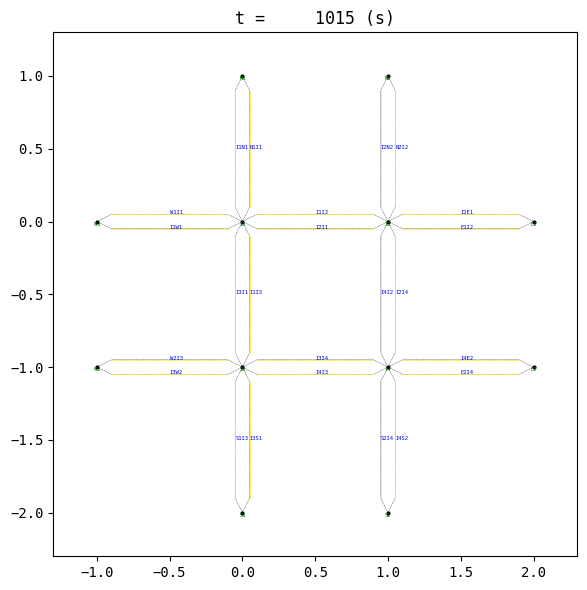

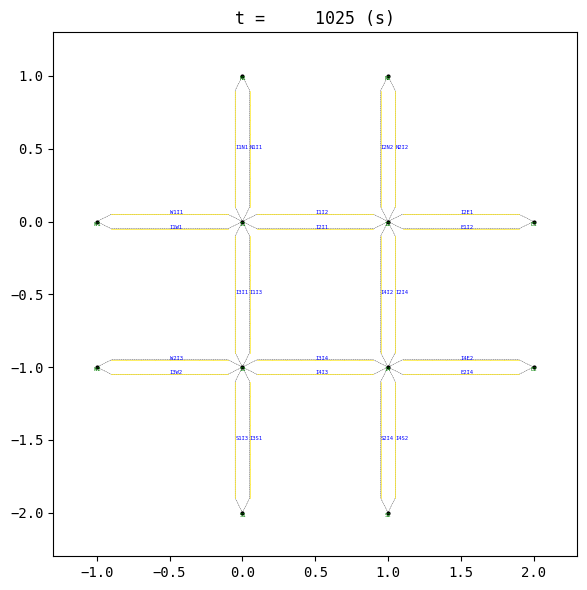

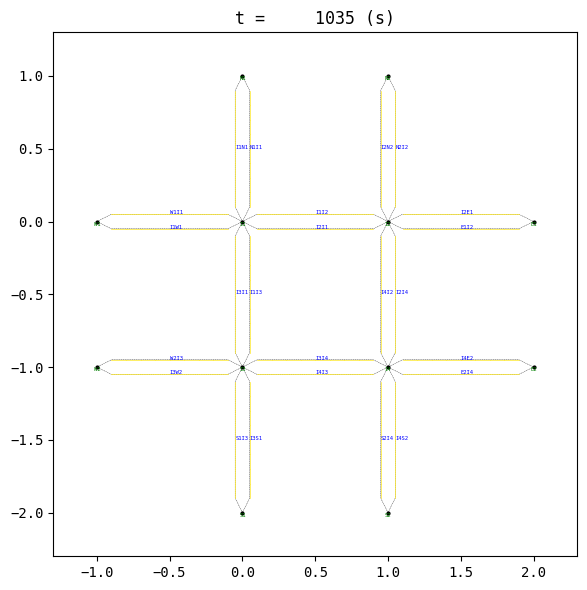

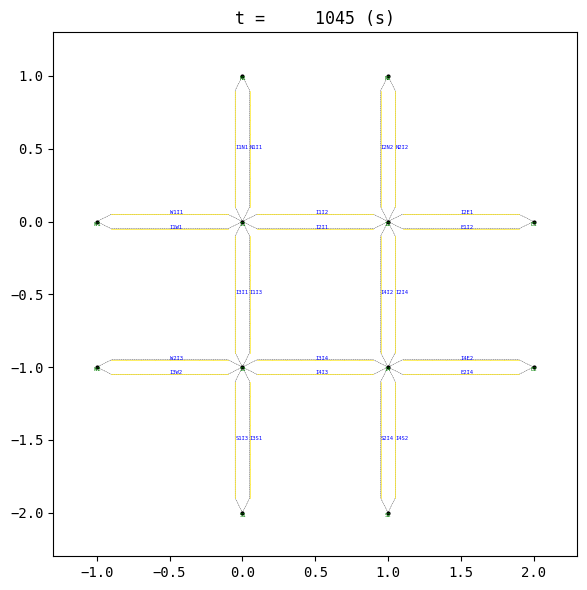

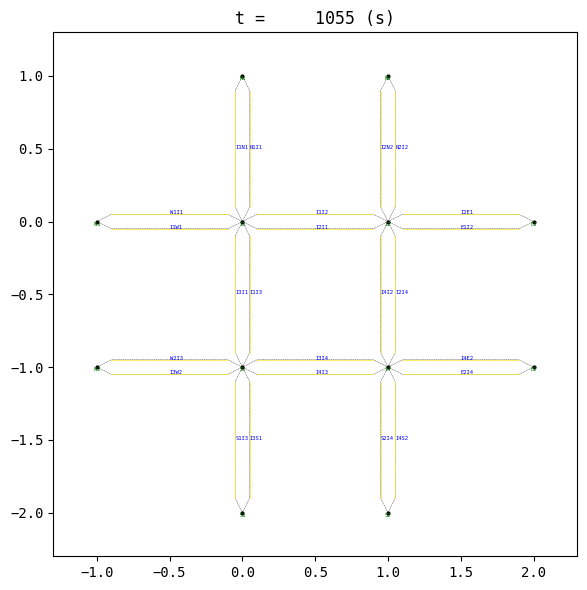

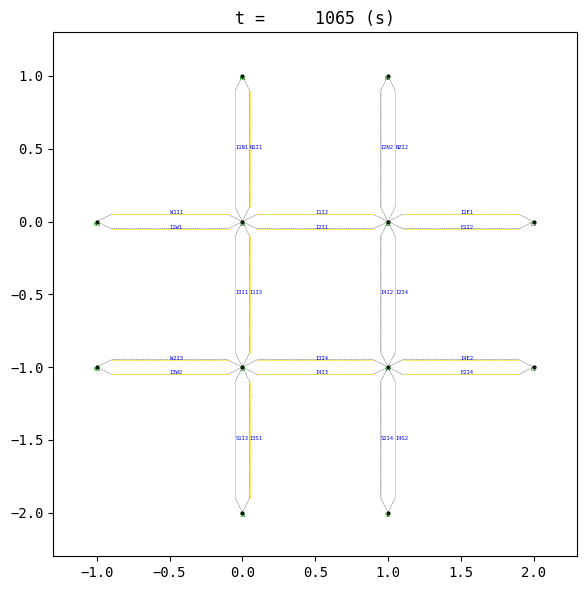

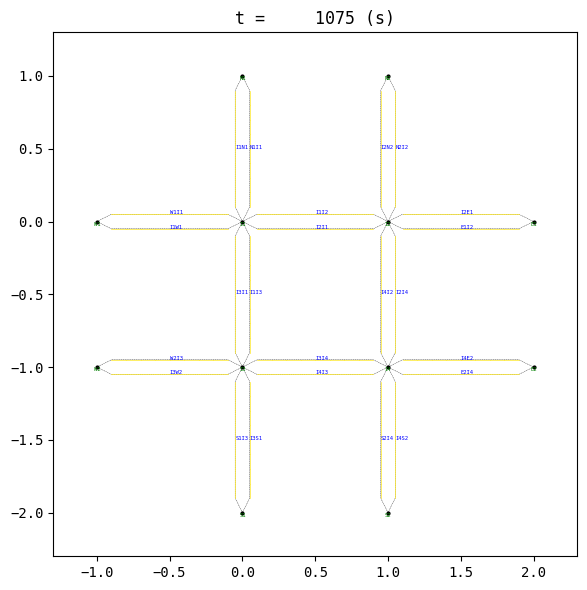

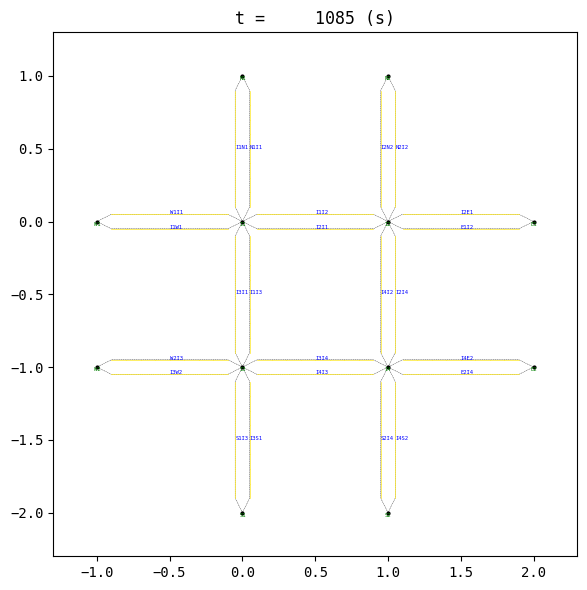

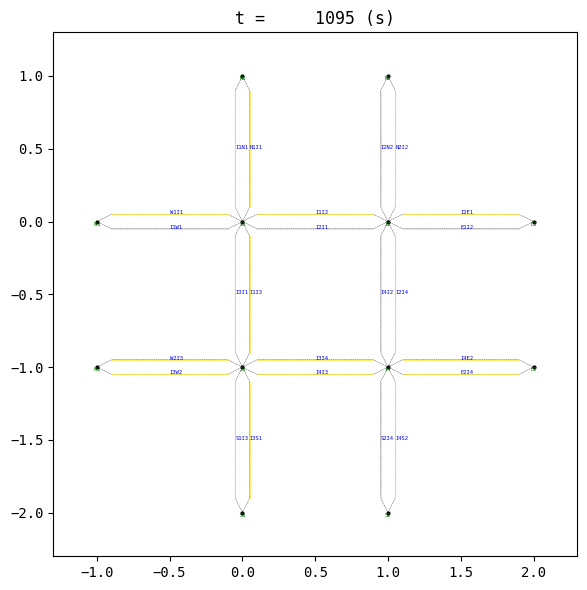

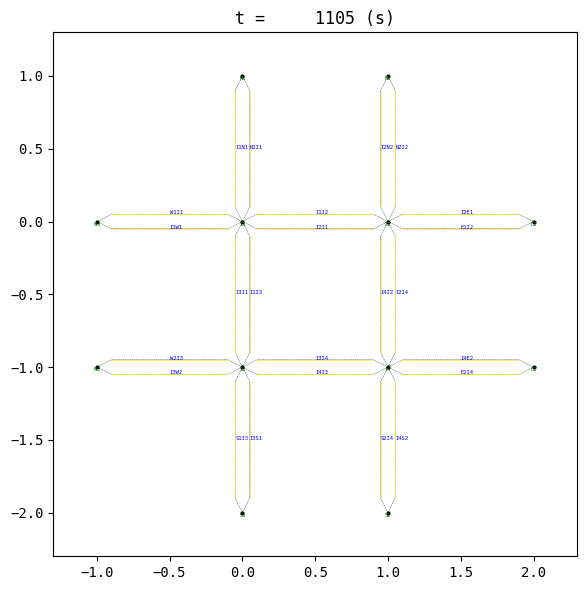

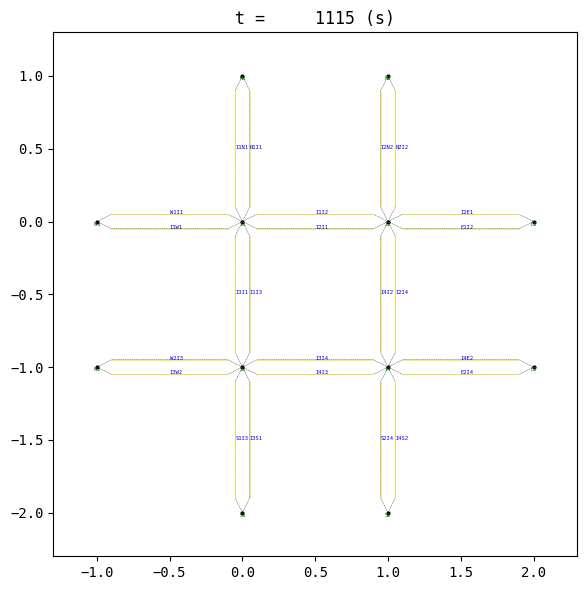

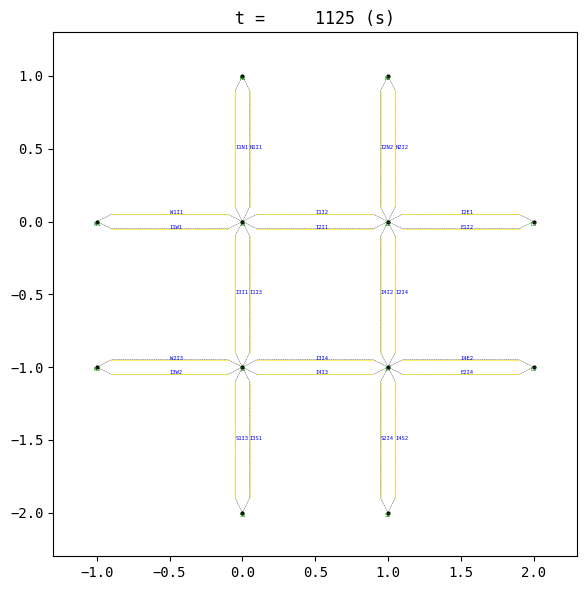

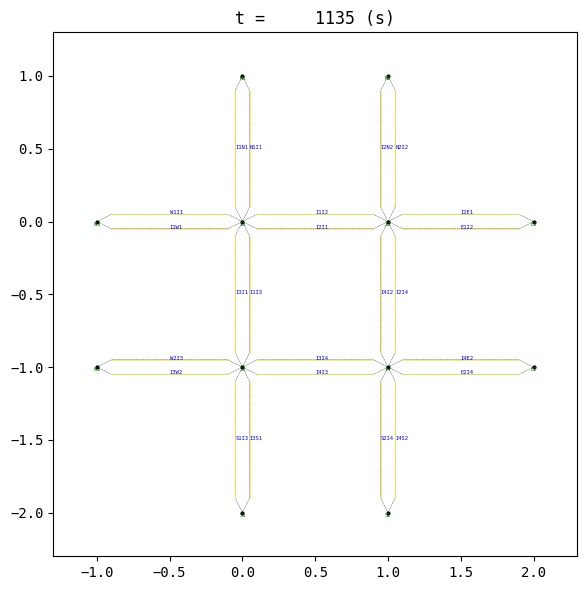

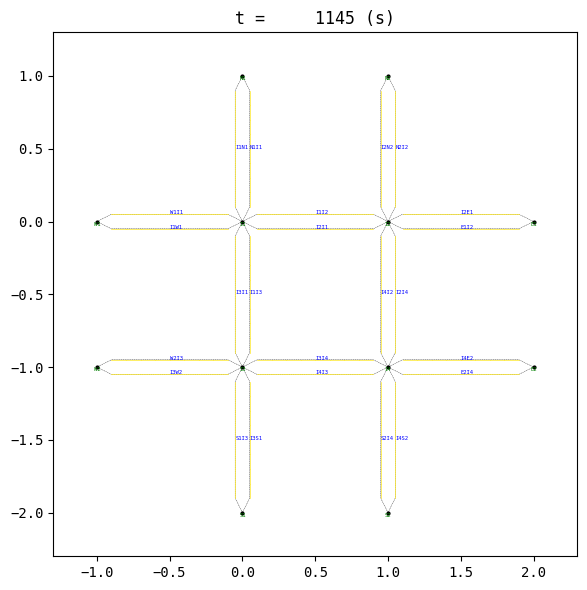

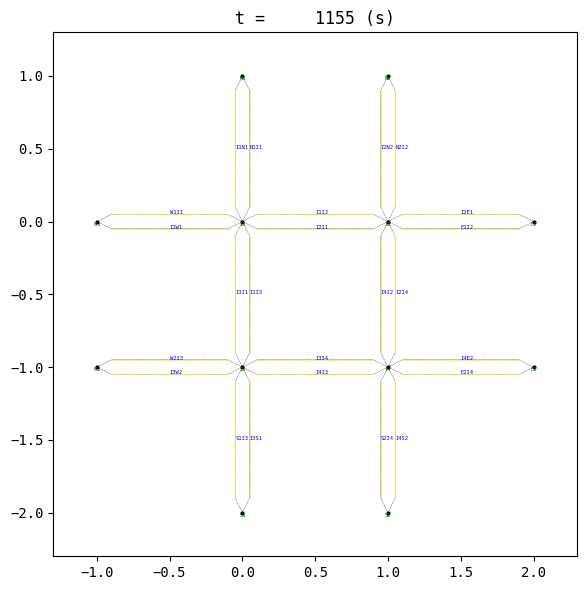

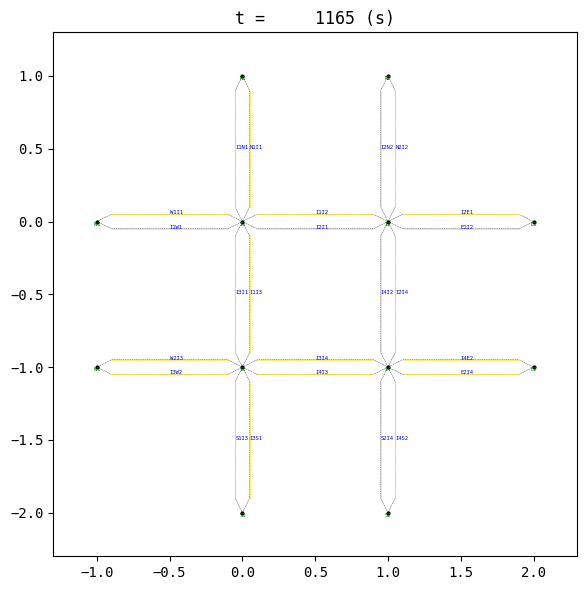

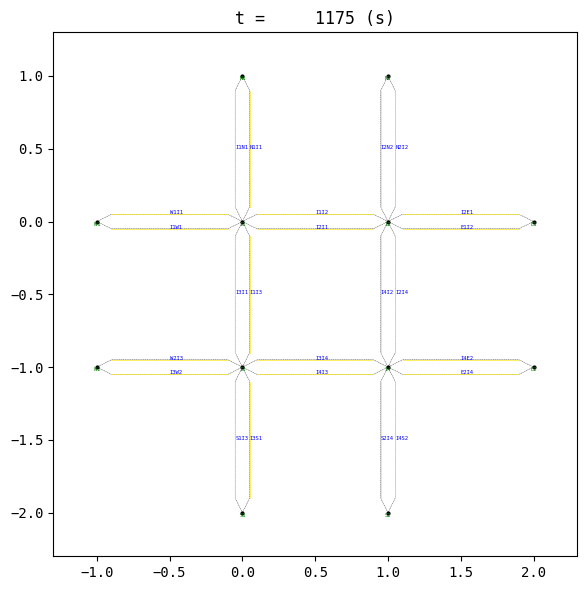

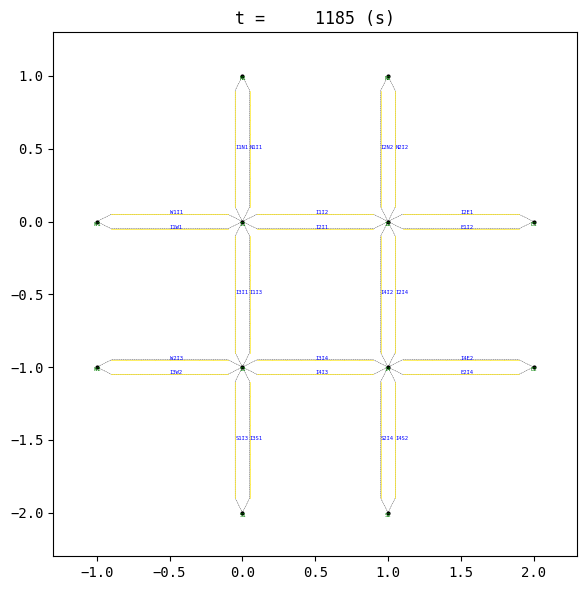

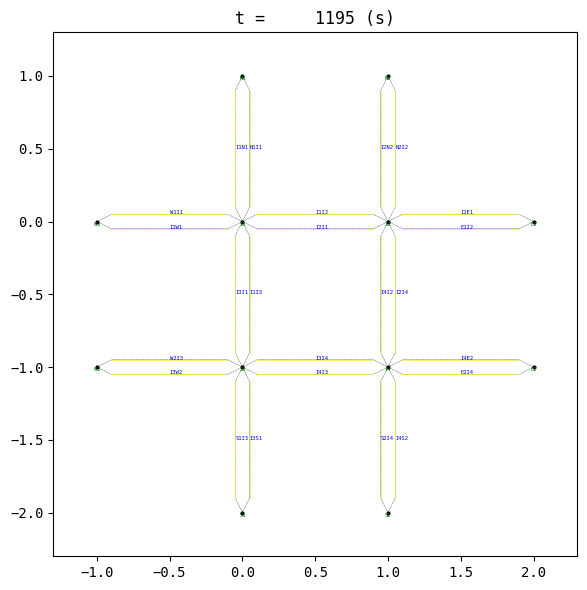

KeyboardInterrupt: 

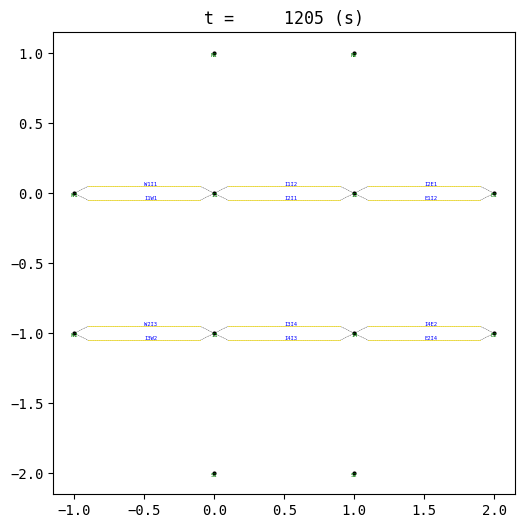

In [51]:
policy.eval()
policy.set_eps(0.05)
collector = ts.data.Collector(policy, env, exploration_noise=True)
collector.collect(n_episode=1, render=1/35)